In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

In [2]:
## Name model, and load and preprocess dataset

In [3]:
# Define number of epochs used later in training
num_epochs = 500

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "Transformer_AdjustSNR_87Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [4]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset87_400MHz_AdjustSNR_Spec.npy')
spectra100 = np.load('Dataset87_100MHz_AdjustSNR_Spec.npy')
conc1 = np.load('Dataset87_AdjustSNR_Conc.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset87_400MHz_AdjustSNR_Val_Spec.npy')
#spectraVal100 = np.load('Dataset87_100MHz_AdjustSNR_Val_Spec.npy')
#pectraValConc = np.load('Dataset87_AdjustSNR_Val_Conc.npy')

# Load representative validation spectra
#RepSpectra400 = np.load("Dataset87_400MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
#RepSpectra100 = np.load("Dataset87_100MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
#RepConc = np.load("Dataset87_AdjustSNR_RepresentativeExamples_Concentrations.npy")
#RepSpecNames = np.load("Dataset87_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
#RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)   # These spectra are the representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#spectraVal400 = torch.tensor(spectraVal400).float().to(device)
#RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 32, shuffle=True)

In [7]:
del X_train
del X_test
del y_train
del y_test

In [5]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, num_bins, input_dim)
        
        # Reconstruct original sequence
        x = x.view(batch_size, -1)  # (batch_size, seq_length)
        return x

# Parameters
input_dim =  1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 8         # Number of attention heads
num_encoder_layers = 6  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.1     # Dropout rate

# Initialize the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)


/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            #inputs = inputs.unsqueeze(1)
            #targets = targets.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                #inputs = inputs.unsqueeze(1)
                #targets = targets.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [11]:
## Not 100% sure, but fairly confident this was run with bin size of 1000

## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 105.1251, Test Loss: 1.8570
Epoch [2/500], Train Loss: 7.5786, Test Loss: 1.8558
Epoch [3/500], Train Loss: 7.4091, Test Loss: 1.8576
Epoch [4/500], Train Loss: 7.3820, Test Loss: 1.8513
Epoch [5/500], Train Loss: 7.3626, Test Loss: 1.8559
Epoch [6/500], Train Loss: 7.3595, Test Loss: 1.8518
Epoch [7/500], Train Loss: 7.3486, Test Loss: 1.8532
Epoch [8/500], Train Loss: 7.3422, Test Loss: 1.8490
Epoch [9/500], Train Loss: 7.3444, Test Loss: 1.8575
Epoch [10/500], Train Loss: 7.3338, Test Loss: 1.8479
Epoch [11/500], Train Loss: 7.3366, Test Loss: 1.8673
Epoch [12/500], Train Loss: 7.3259, Test Loss: 1.8490
Epoch [13/500], Train Loss: 7.3214, Test Loss: 1.8476
Epoch [14/500], Train Loss: 7.3194, Test Loss: 1.8475
Epoch [15/500], Train Loss: 7.3146, Test Loss: 1.8507


KeyboardInterrupt: 

In [10]:
## This run accidentally had 200 data point bins instead of 1000............

## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params2.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 105.8107, Test Loss: 1.8746
Epoch [2/500], Train Loss: 7.6054, Test Loss: 1.8616
Epoch [3/500], Train Loss: 5.0033, Test Loss: 1.0094
Epoch [4/500], Train Loss: 4.0591, Test Loss: 0.8001
Epoch [5/500], Train Loss: 3.2195, Test Loss: 0.6501
Epoch [6/500], Train Loss: 2.5209, Test Loss: 0.5019
Epoch [7/500], Train Loss: 1.9976, Test Loss: 0.3856
Epoch [8/500], Train Loss: 1.6481, Test Loss: 0.3302
Epoch [9/500], Train Loss: 1.3750, Test Loss: 0.2631
Epoch [10/500], Train Loss: 1.1712, Test Loss: 0.2227
Epoch [11/500], Train Loss: 1.0209, Test Loss: 0.1946
Epoch [12/500], Train Loss: 0.9110, Test Loss: 0.1761
Epoch [13/500], Train Loss: 0.8248, Test Loss: 0.1655
Epoch [14/500], Train Loss: 0.7554, Test Loss: 0.1533
Epoch [15/500], Train Loss: 0.7002, Test Loss: 0.1524
Epoch [16/500], Train Loss: 0.6483, Test Loss: 0.1297
Epoch [17/500], Train Loss: 0.6113, Test Loss: 0.1253
Epoch [18/500], Train Loss: 0.5777, Tes

KeyboardInterrupt: 

In [10]:
## This time definitely ran with 1000 bin size

## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params3.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 96.1839, Test Loss: 1.8566
Epoch [2/500], Train Loss: 7.6979, Test Loss: 1.8528
Epoch [3/500], Train Loss: 7.4257, Test Loss: 1.8508
Epoch [4/500], Train Loss: 7.3844, Test Loss: 1.8597
Epoch [5/500], Train Loss: 7.3702, Test Loss: 1.8534
Epoch [6/500], Train Loss: 7.3615, Test Loss: 1.8559
Epoch [7/500], Train Loss: 7.3567, Test Loss: 1.8529
Epoch [8/500], Train Loss: 7.3474, Test Loss: 1.8529
Epoch [9/500], Train Loss: 7.3486, Test Loss: 1.8560
Epoch [10/500], Train Loss: 7.3381, Test Loss: 1.8492
Epoch [11/500], Train Loss: 7.3358, Test Loss: 1.8568
Epoch [12/500], Train Loss: 7.3288, Test Loss: 1.8633
Epoch [13/500], Train Loss: 7.3272, Test Loss: 1.8503
Epoch [14/500], Train Loss: 7.3219, Test Loss: 1.8487
Epoch [15/500], Train Loss: 7.3165, Test Loss: 1.8467
Epoch [16/500], Train Loss: 7.3154, Test Loss: 1.8463
Epoch [17/500], Train Loss: 7.3123, Test Loss: 1.8466
Epoch [18/500], Train Loss: 7.3111, Test

KeyboardInterrupt: 

In [12]:
## This time definitely ran with 200 bin size

## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params4.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 109.9550, Test Loss: 1.8705
Epoch [2/500], Train Loss: 7.5435, Test Loss: 1.8689
Epoch [3/500], Train Loss: 7.4341, Test Loss: 1.8665
Epoch [4/500], Train Loss: 7.4004, Test Loss: 1.8589
Epoch [5/500], Train Loss: 7.3862, Test Loss: 1.8726
Epoch [6/500], Train Loss: 7.3893, Test Loss: 1.8704
Epoch [7/500], Train Loss: 7.3836, Test Loss: 1.8680
Epoch [8/500], Train Loss: 7.3802, Test Loss: 1.8603
Epoch [9/500], Train Loss: 7.3792, Test Loss: 1.8612


KeyboardInterrupt: 

In [14]:
## This time definitely ran with 1000 bin size

## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params5.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 94.0028, Test Loss: 1.8130
Epoch [2/500], Train Loss: 6.1669, Test Loss: 1.2327
Epoch [3/500], Train Loss: 4.1628, Test Loss: 0.8047
Epoch [4/500], Train Loss: 2.9800, Test Loss: 0.5733
Epoch [5/500], Train Loss: 2.3176, Test Loss: 0.4540
Epoch [6/500], Train Loss: 1.8679, Test Loss: 0.3693
Epoch [7/500], Train Loss: 1.5769, Test Loss: 0.3196
Epoch [8/500], Train Loss: 1.3602, Test Loss: 0.2714
Epoch [9/500], Train Loss: 1.1934, Test Loss: 0.2428
Epoch [10/500], Train Loss: 1.0528, Test Loss: 0.2136
Epoch [11/500], Train Loss: 0.9383, Test Loss: 0.1897
Epoch [12/500], Train Loss: 0.8435, Test Loss: 0.1657
Epoch [13/500], Train Loss: 0.7603, Test Loss: 0.1476
Epoch [14/500], Train Loss: 0.6842, Test Loss: 0.1304
Epoch [15/500], Train Loss: 0.6170, Test Loss: 0.1242
Epoch [16/500], Train Loss: 0.5596, Test Loss: 0.1068
Epoch [17/500], Train Loss: 0.5096, Test Loss: 0.0959
Epoch [18/500], Train Loss: 0.4626, Test

KeyboardInterrupt: 

In [6]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params5.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=512, out_features=1000, bias=True)
)

In [7]:
## Switch to directory for saving model metrics

os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/ModelPerformanceMetrics')

In [8]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset87_400MHz_AdjustSNR_Val_Spec.npy')
spectraVal100 = np.load('Dataset87_100MHz_AdjustSNR_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)


## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

In [14]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.to(device).eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100])  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print MSE
print('model err: ', mse)  # Print MSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


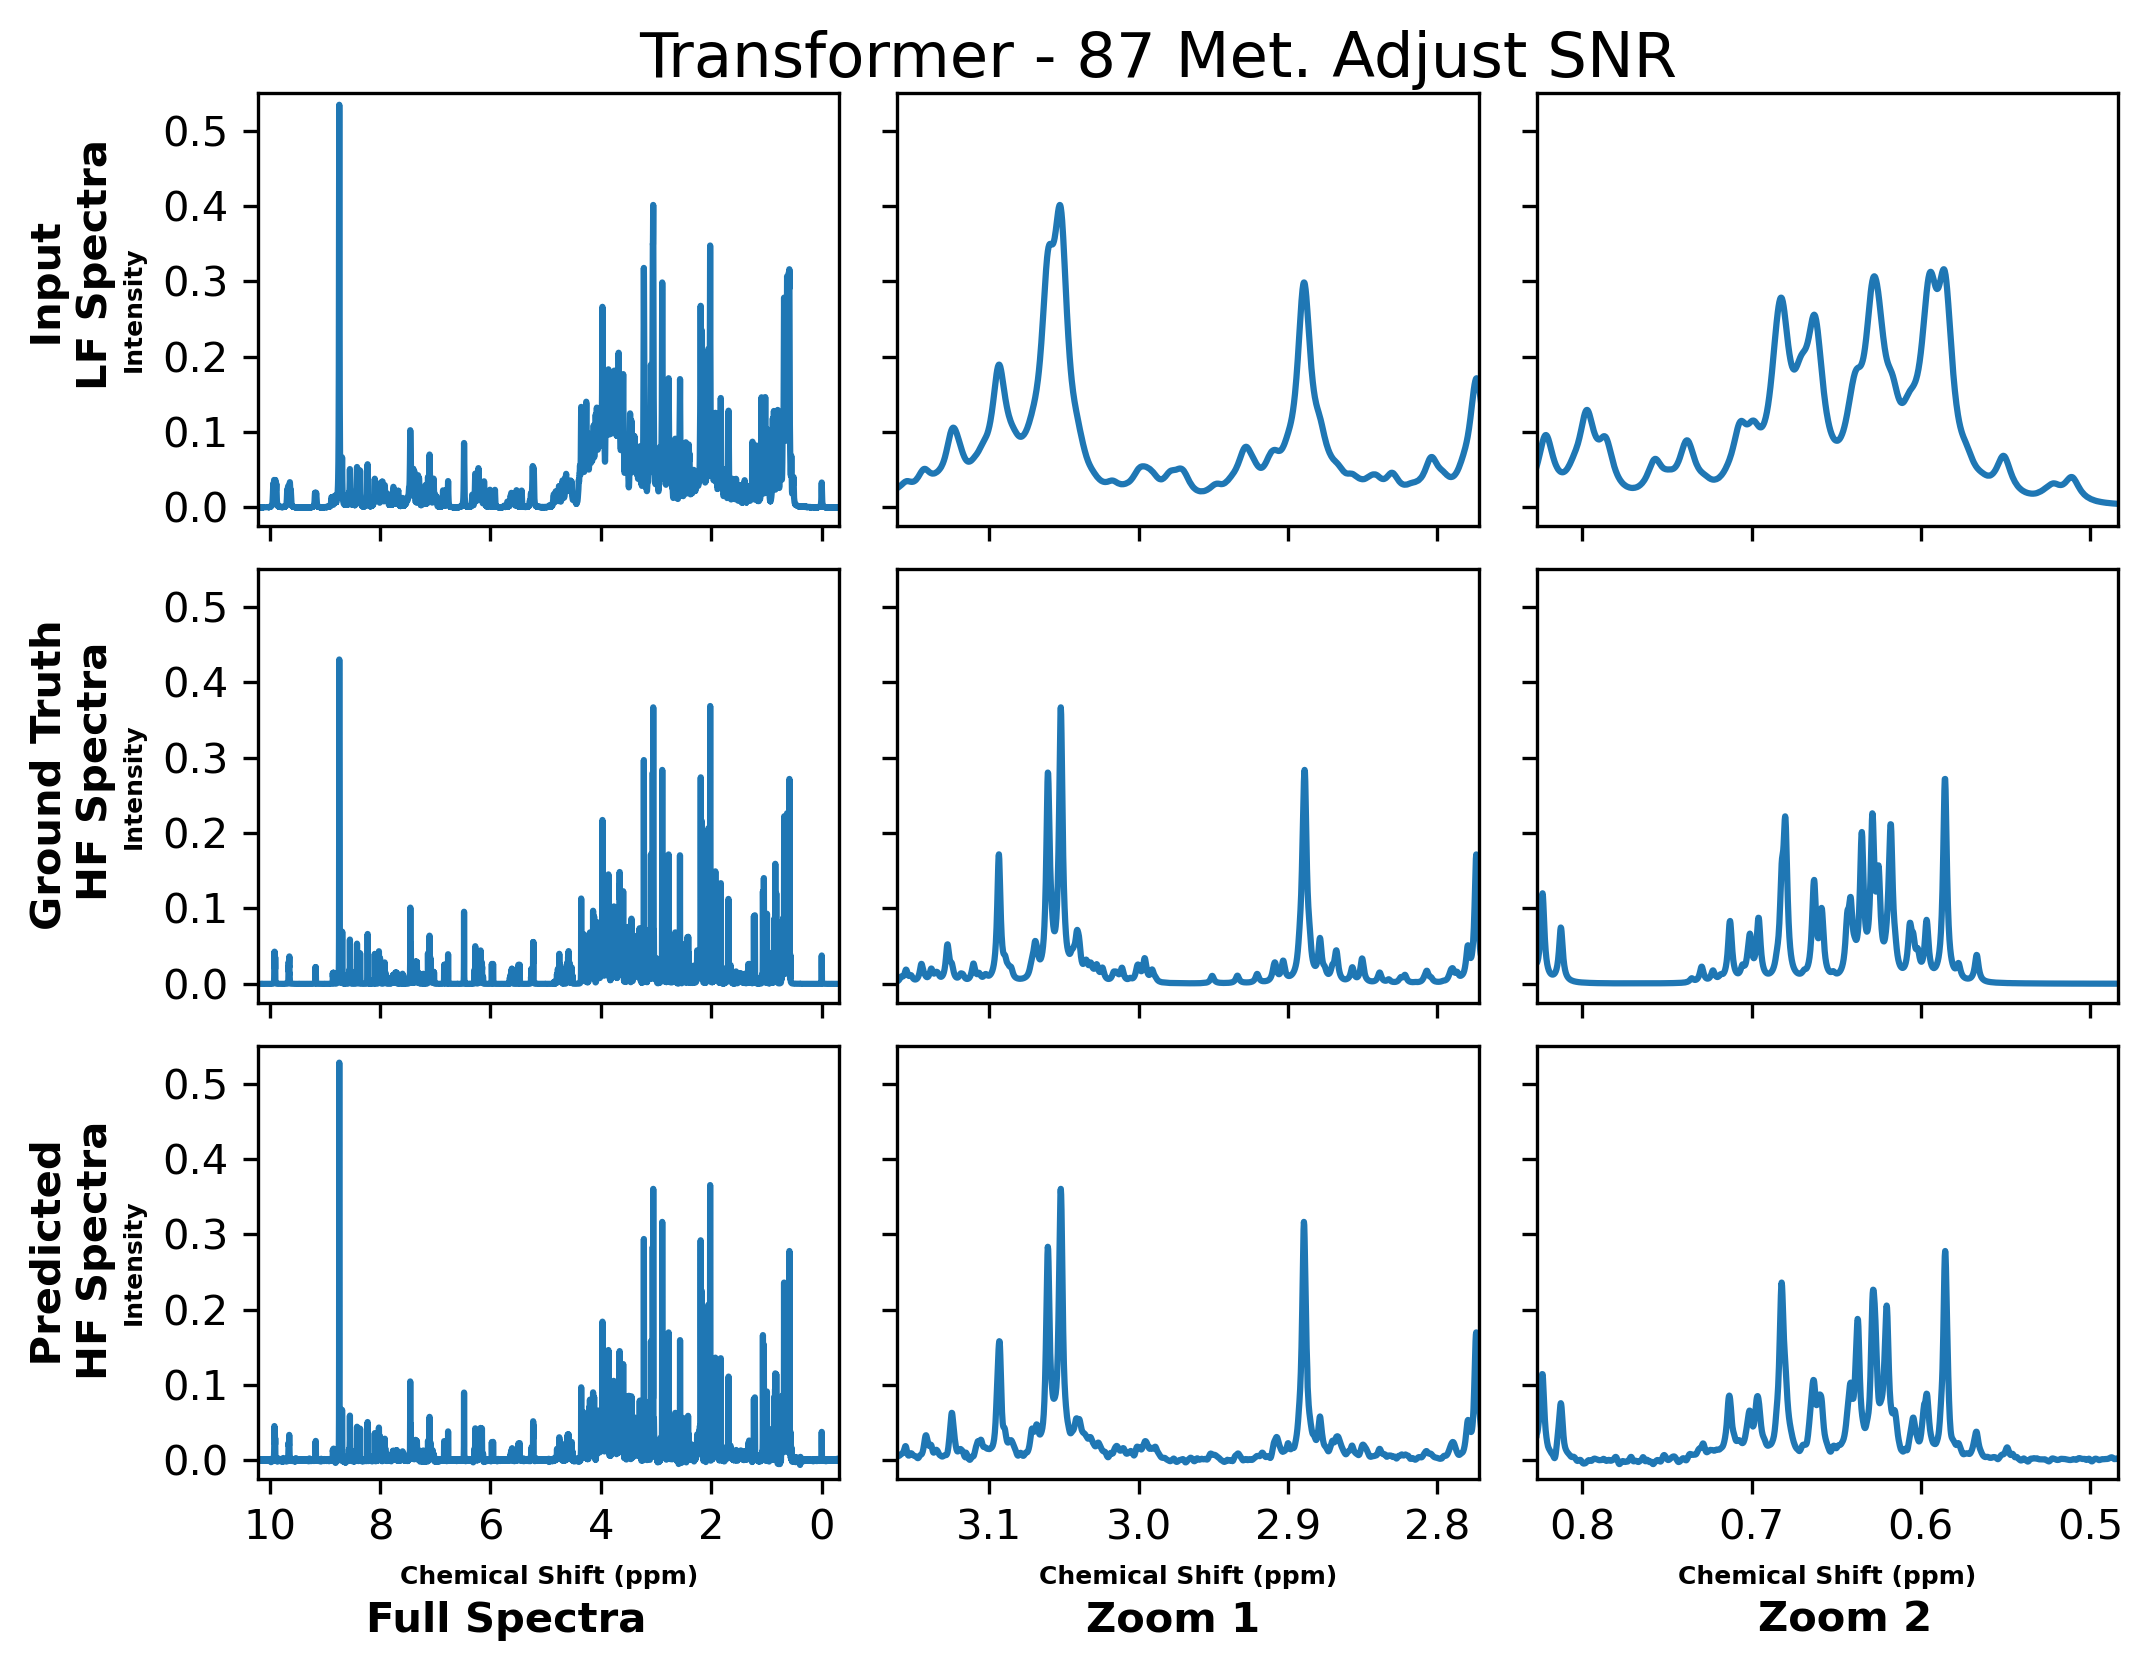

In [9]:
# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space

# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.55)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.55)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.55)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.55)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.55)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.55)

axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.55)
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.55)
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.55)


# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('Transformer - 87 Met. Adjust SNR', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('Transformer_87_AdjustSNR_Visual.png', dpi=600, bbox_inches='tight')

plt.show()

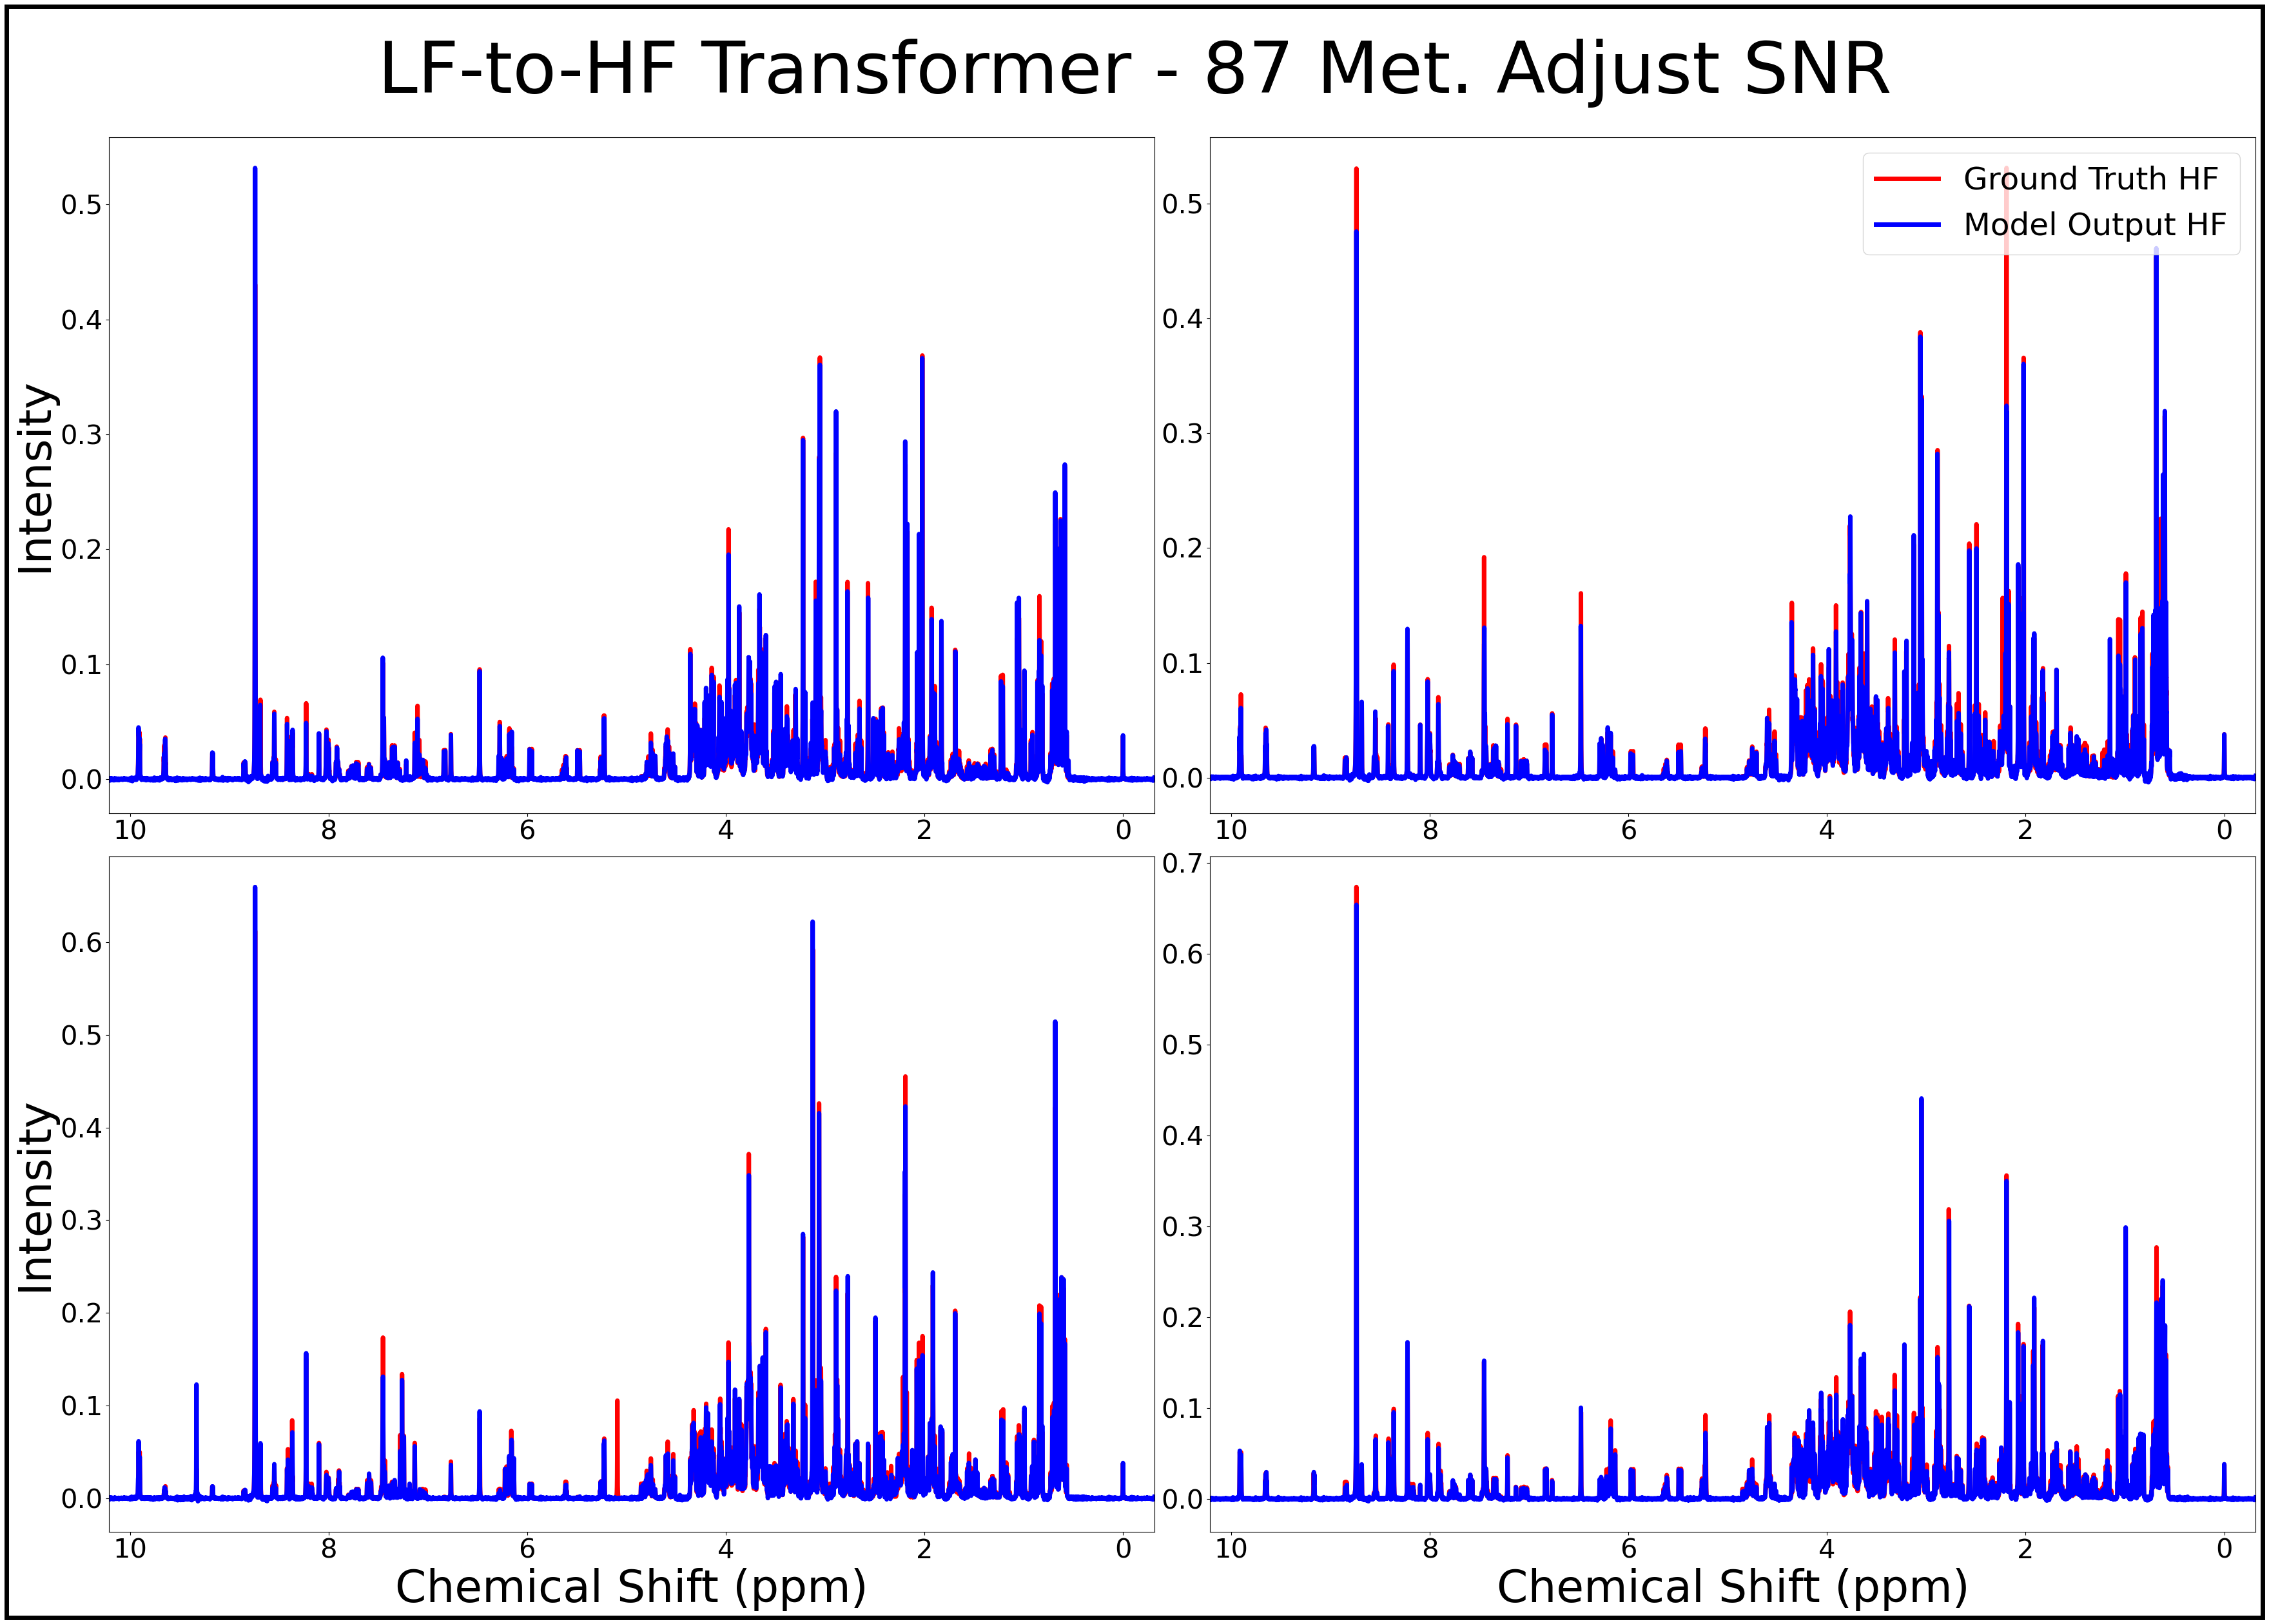

In [10]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


LF = spectraVal100[:100]
GT = spectraVal400[:100]
criterion = nn.MSELoss()



# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])


    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF Transformer - 87 Met. Adjust SNR', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_Transformer-87MetAdjustSNR.png', dpi=600, bbox_inches='tight')

plt.show()

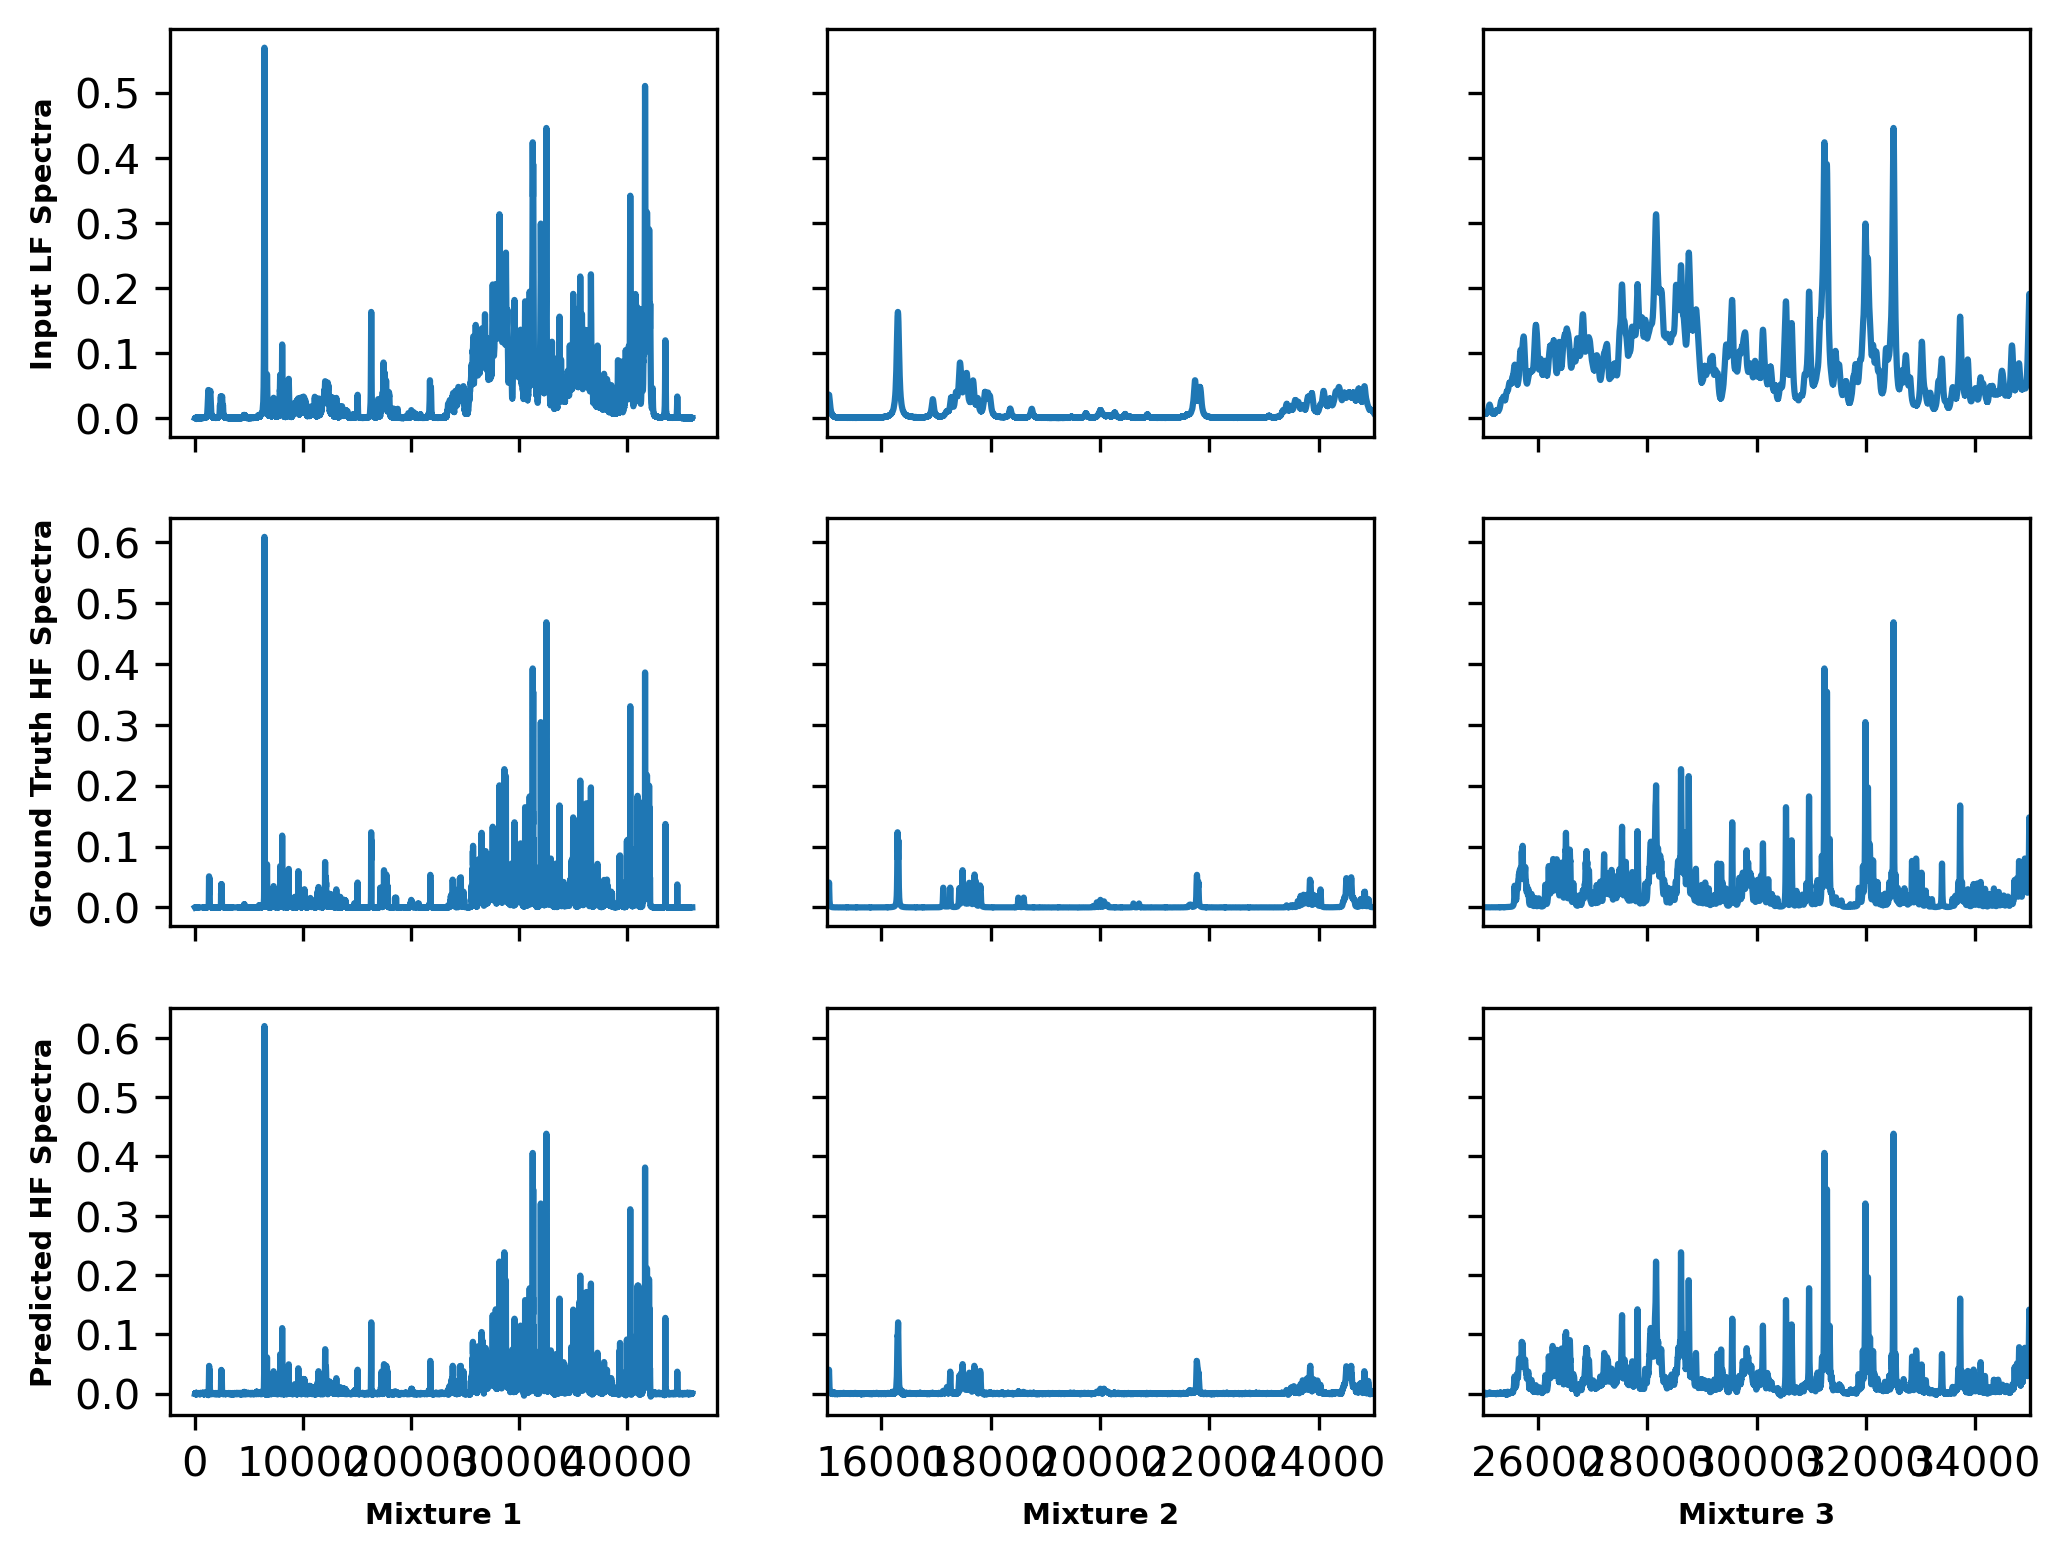

In [11]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

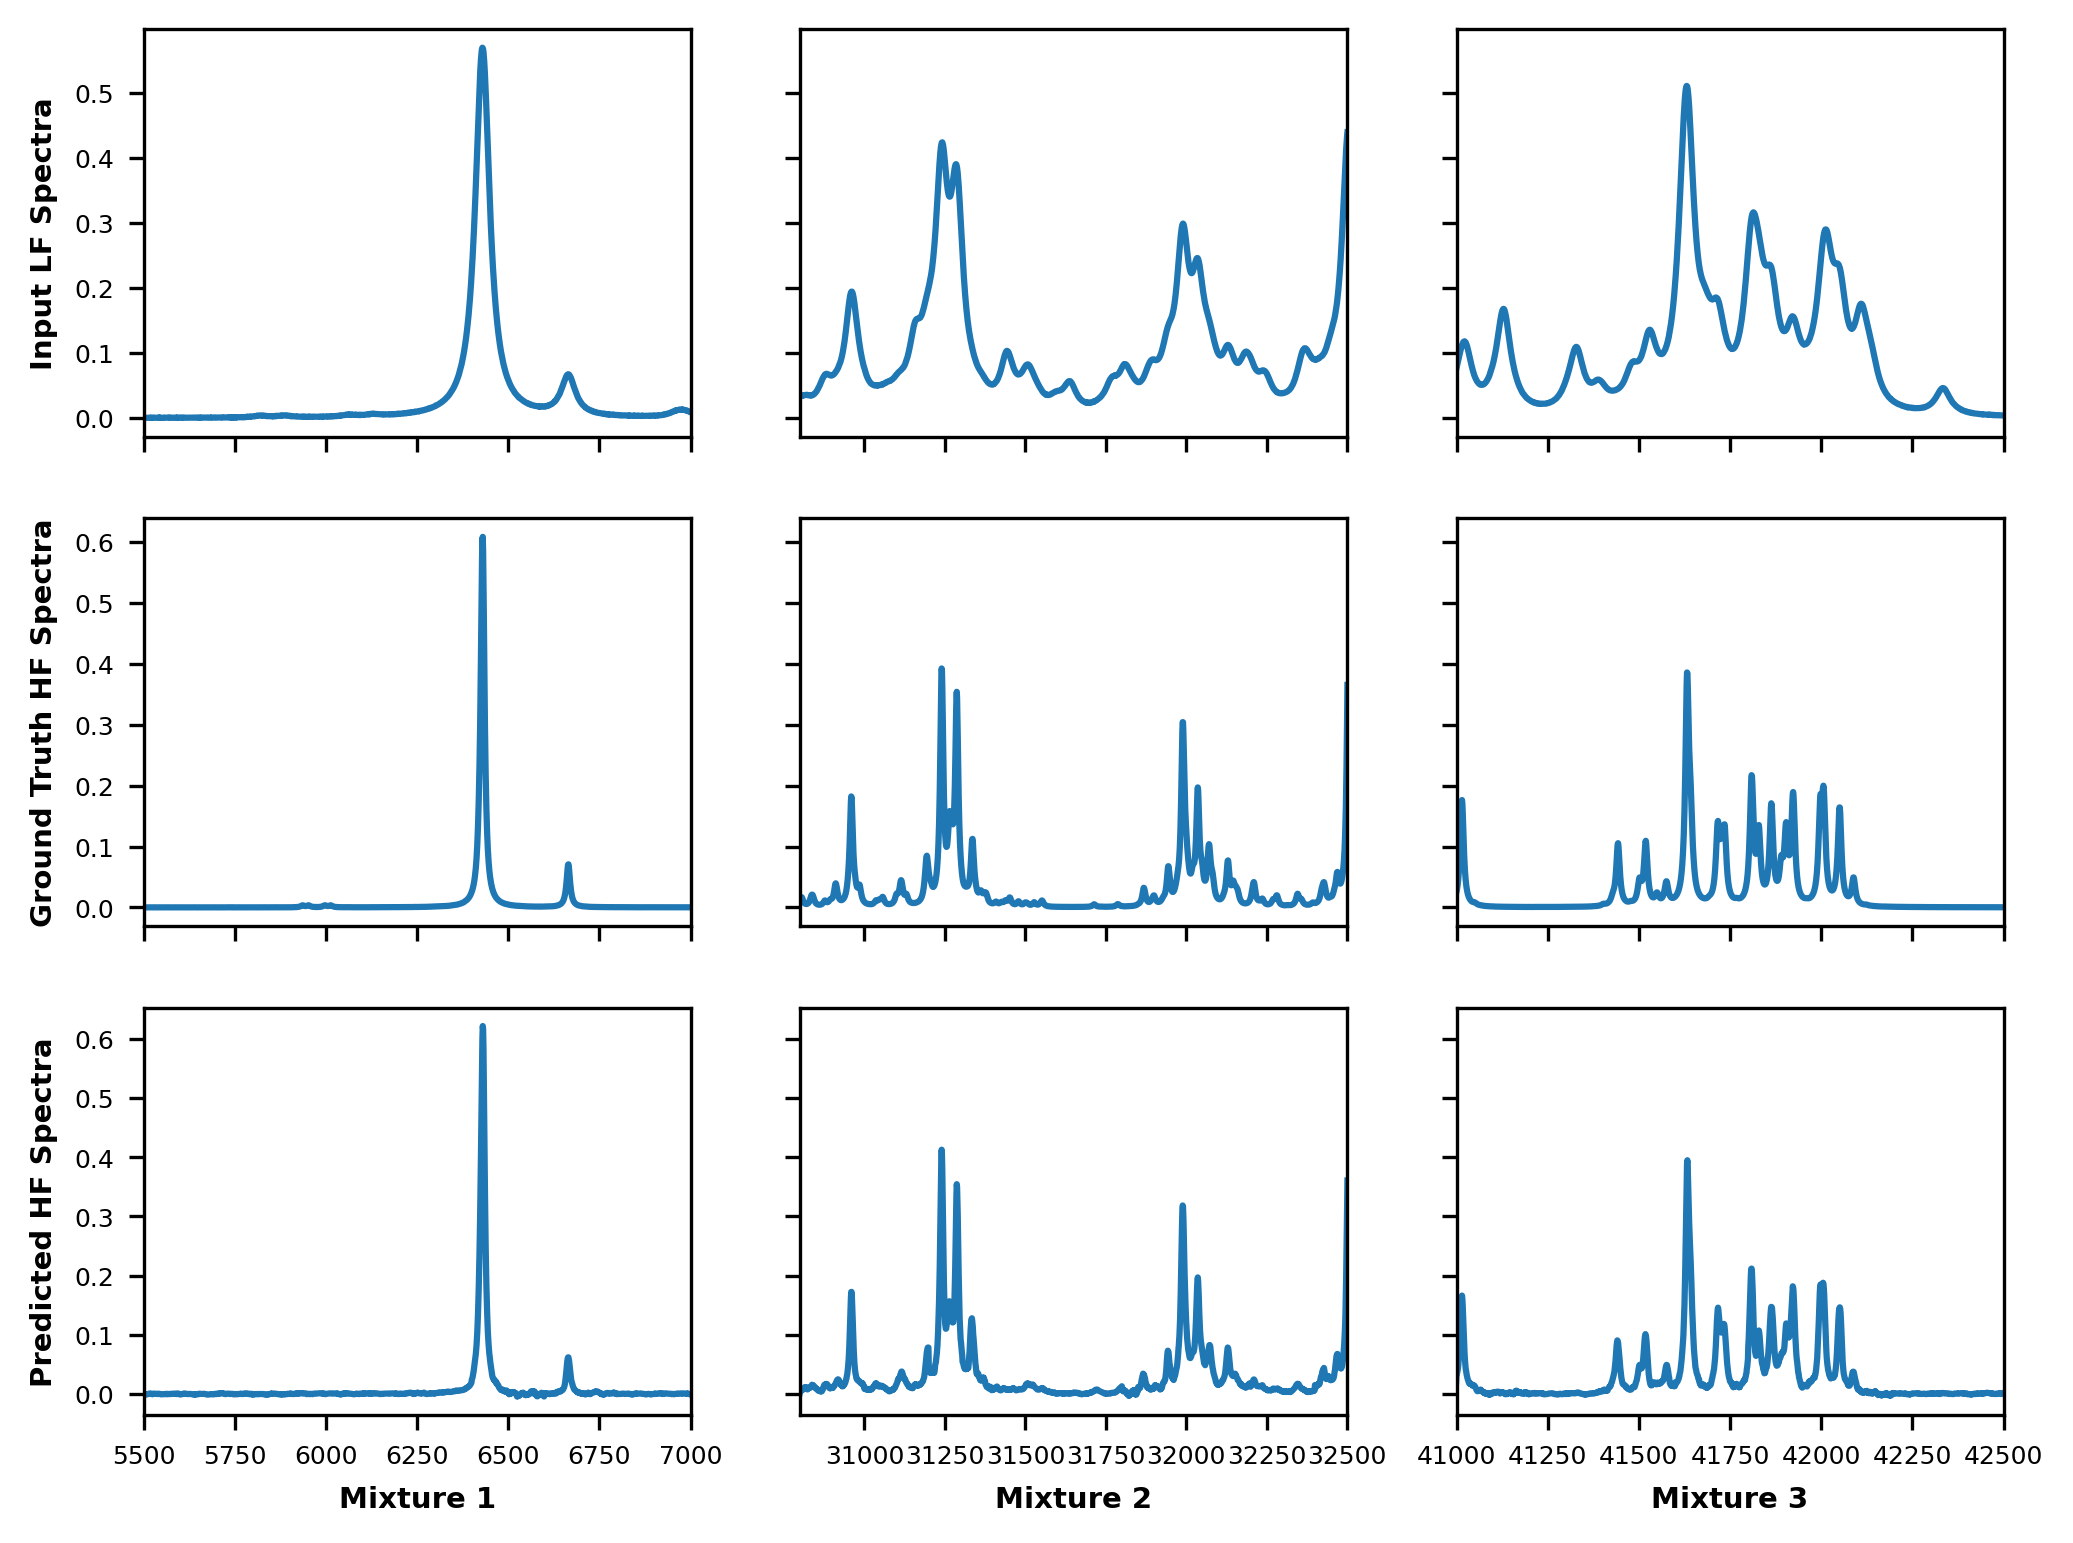

In [12]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
axs[0, 0].set_xlim([5500,7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([30800,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
axs[1, 0].set_xlim([5500,7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([30800,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([5500,7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([30800,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

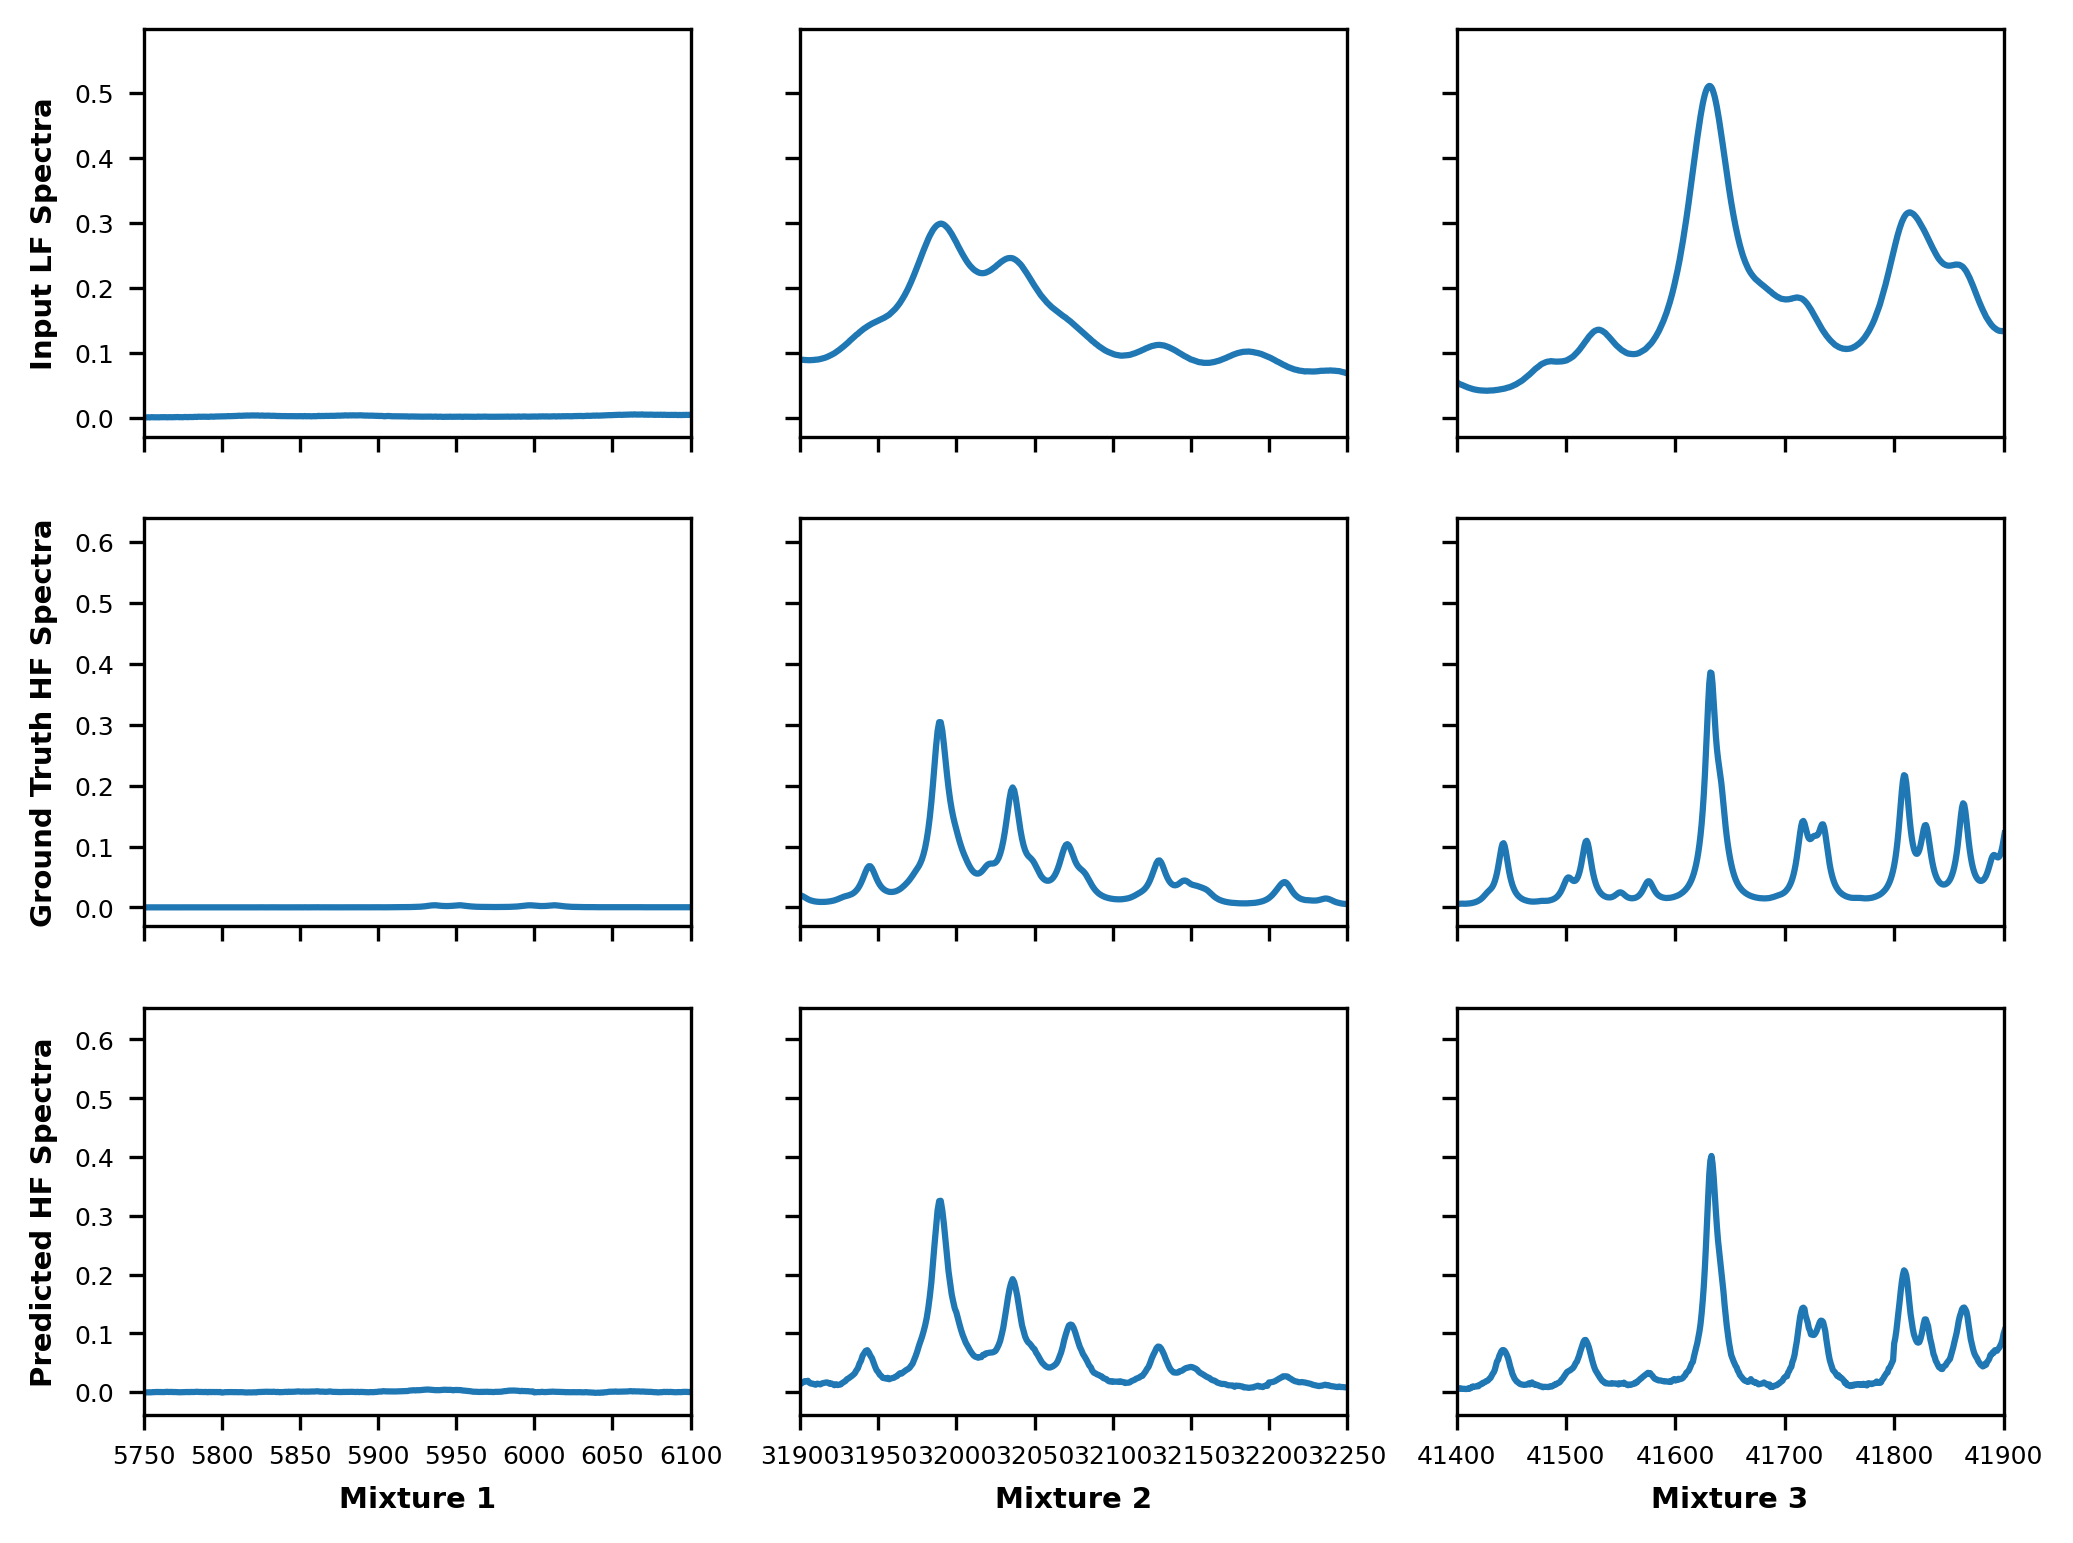

In [13]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
axs[0, 0].set_xlim([5750,6100])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([31900,32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41400,41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
axs[1, 0].set_xlim([5750,6100])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([31900,32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41400,41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([5750,6100])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([31900,32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41400,41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

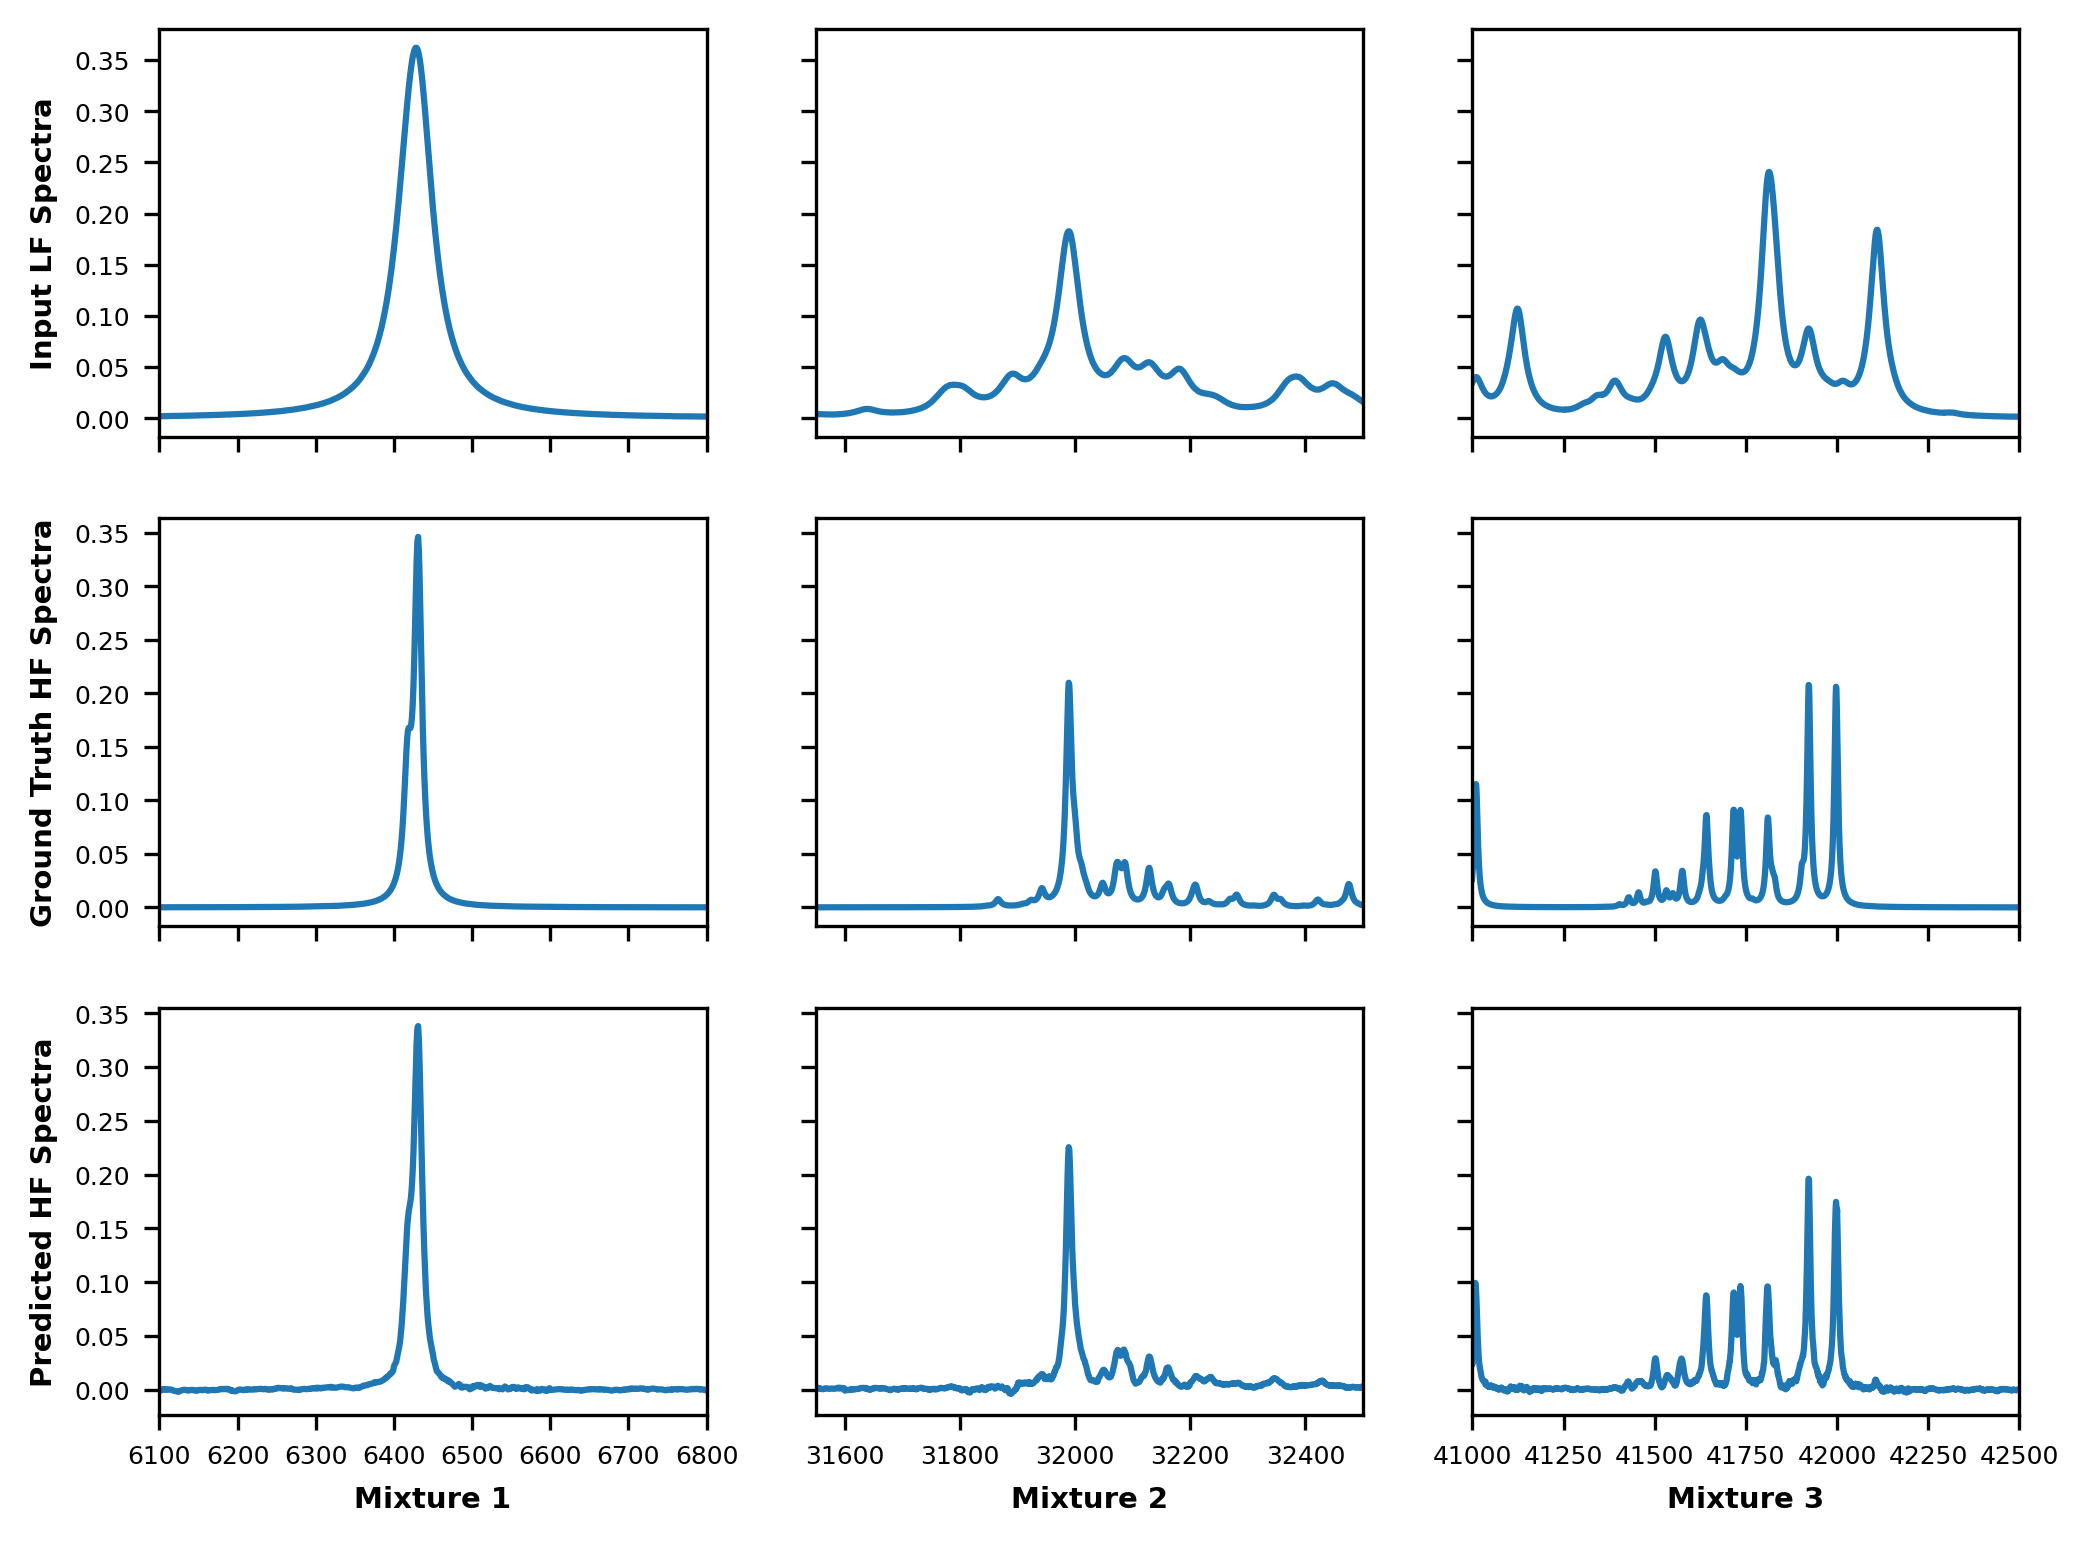

In [14]:
Predicted = model(X_test[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_test[0].cpu().detach().numpy())
axs[0, 0].set_xlim([6100,6800])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_test[0].cpu().detach().numpy())
axs[0, 1].set_xlim([31550,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_test[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_test[0].cpu().detach().numpy())
axs[1, 0].set_xlim([6100,6800])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_test[0].cpu().detach().numpy())
axs[1, 1].set_xlim([31550,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_test[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([6100,6800])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([31550,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

## Test on 12 metabolites not seen in training

In [67]:
# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400_12NewMet = np.load('Dataset21_Other12Met_400MHz_Val_Spec.npy')
spectra100_12NewMet = np.load('Dataset21_Other12Met_100MHz_Val_Spec.npy')
conc_12NewMet = np.load('Dataset21_Other12Met_Val_Conc.npy')

# Prepare for input into model
spectra400_12NewMet = torch.tensor(spectra400_12NewMet).float().to(device)
spectra100_12NewMet = torch.tensor(spectra100_12NewMet).float().to(device)

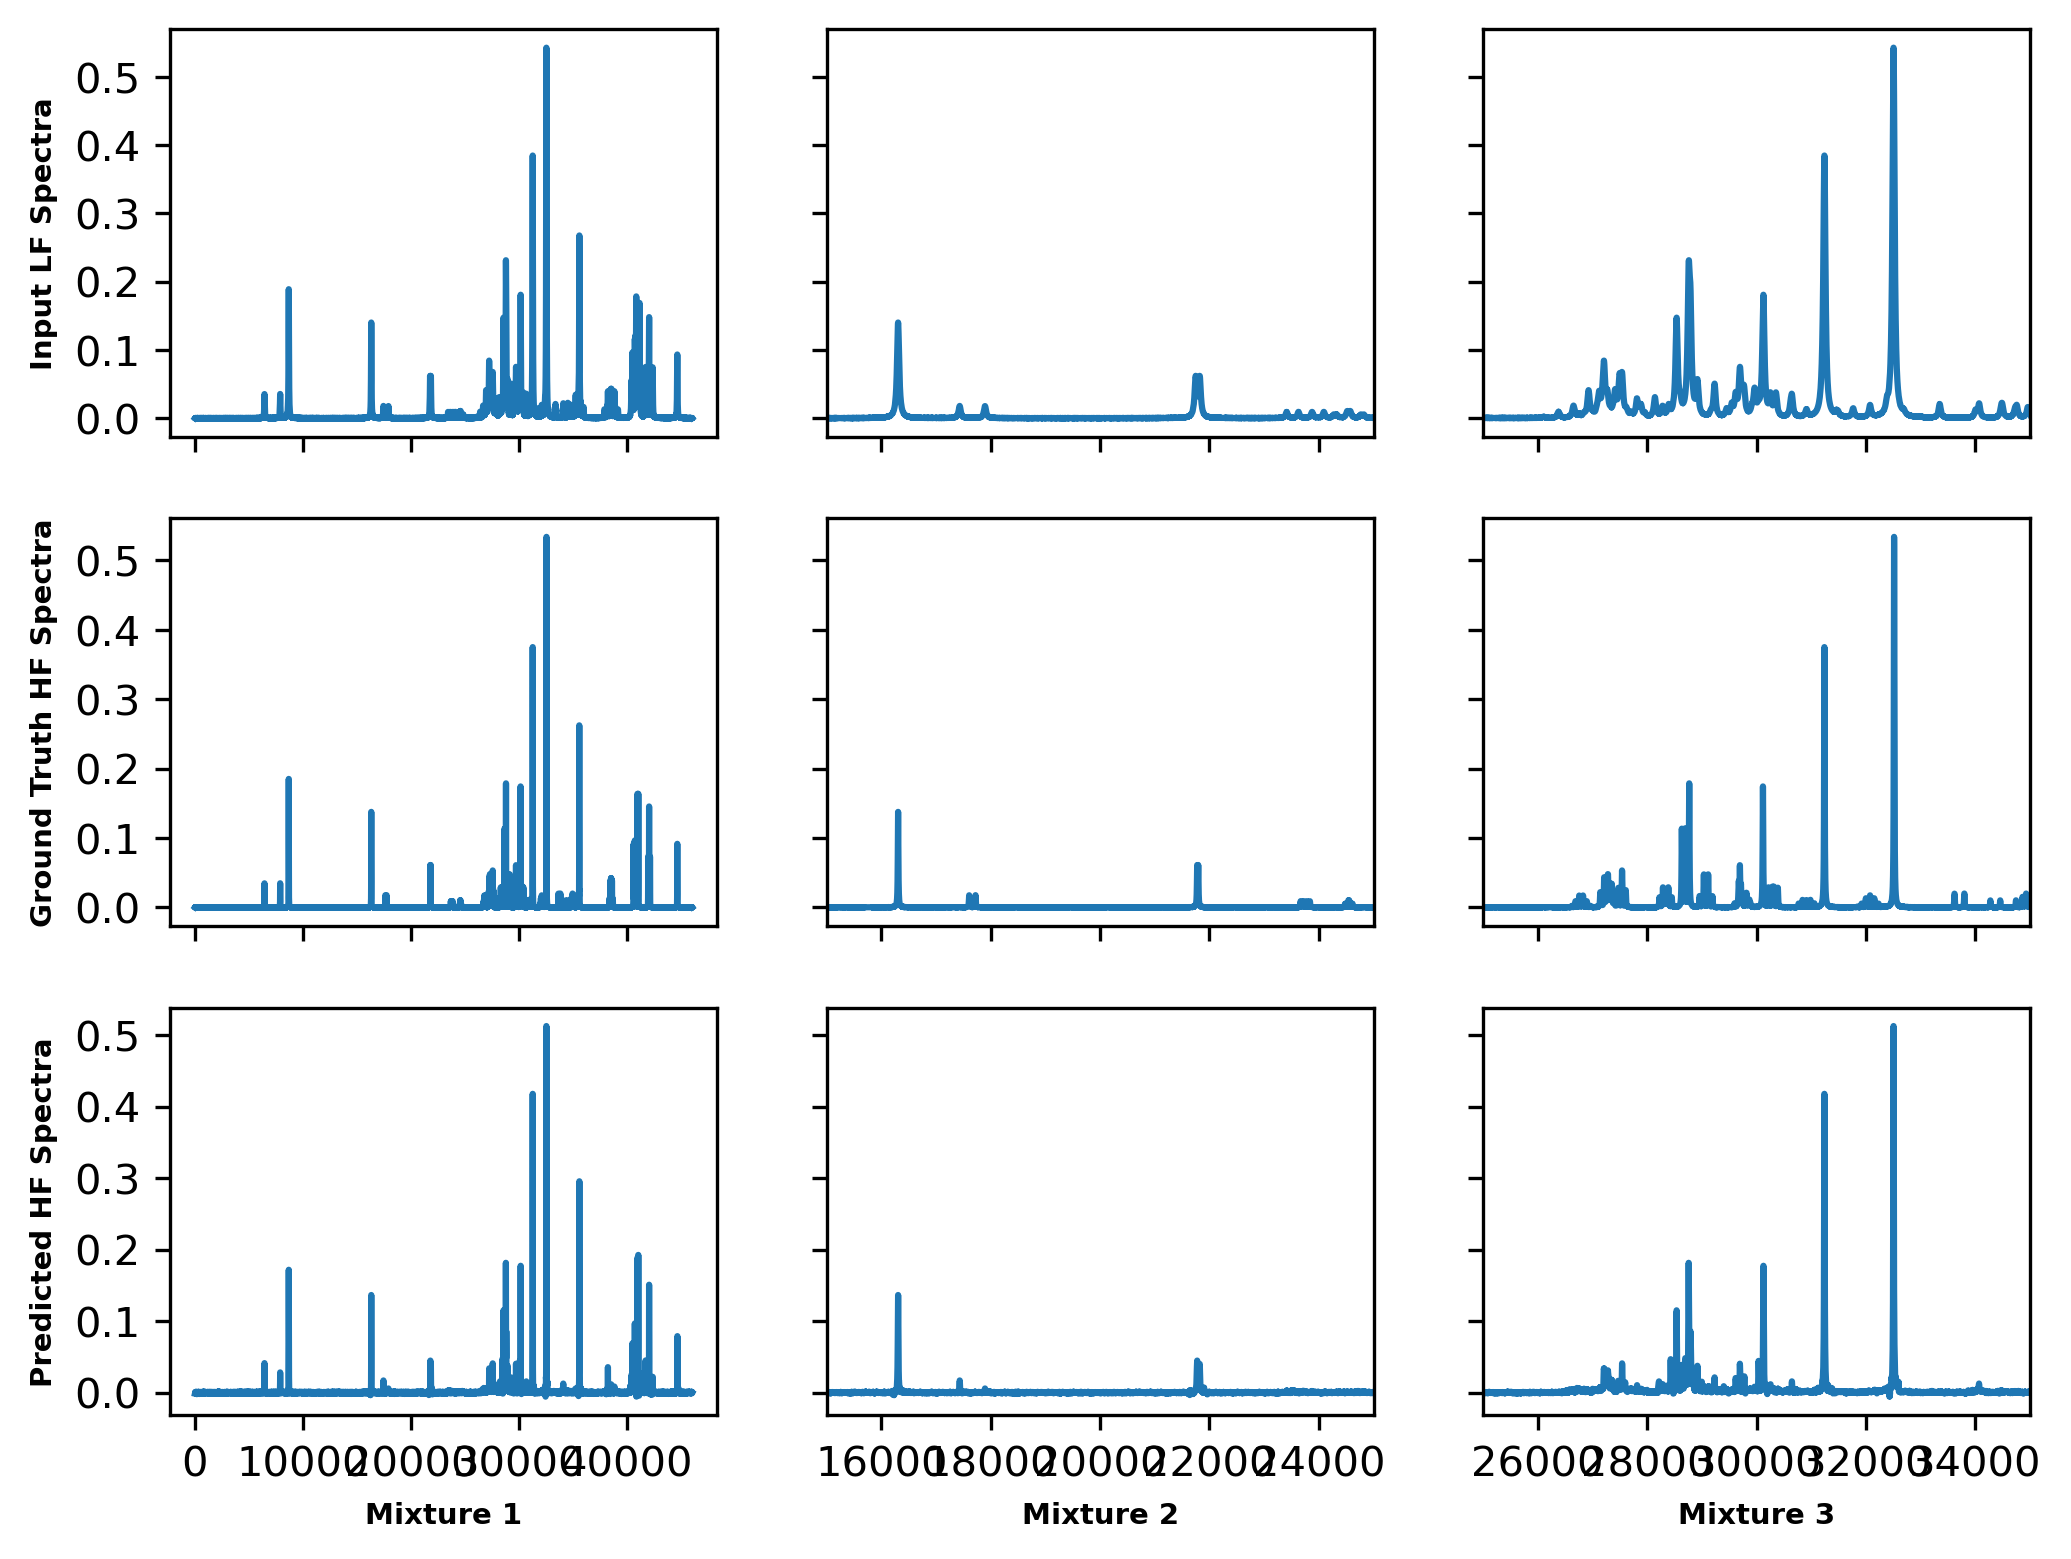

In [68]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

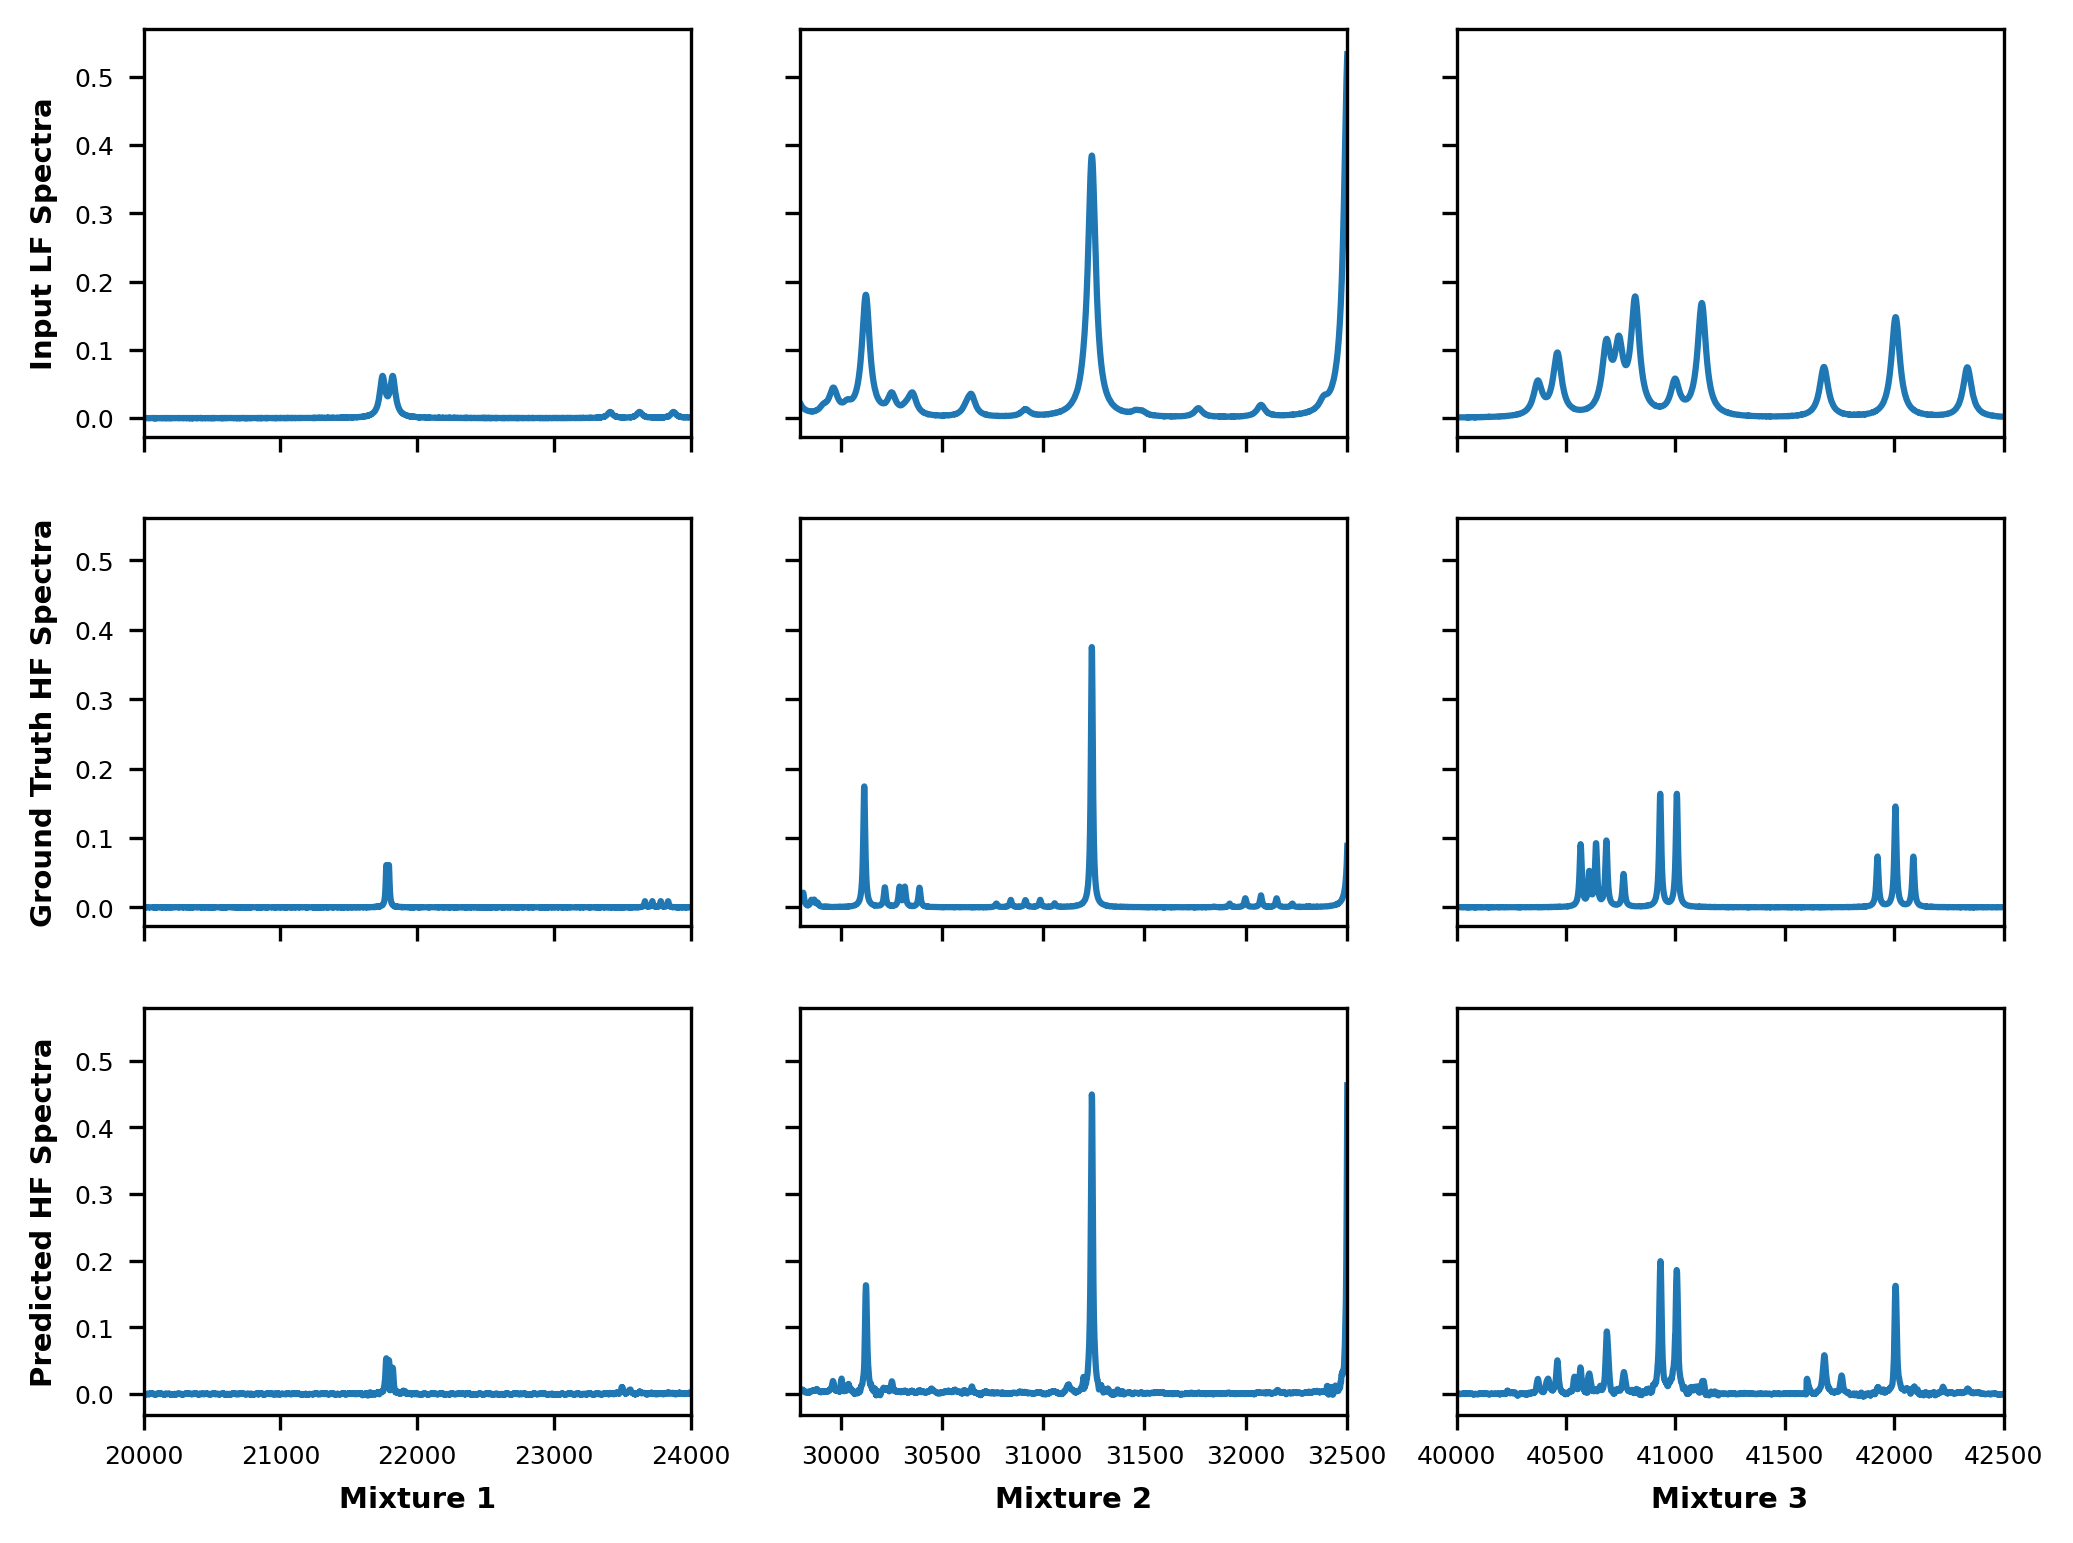

In [69]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 0].set_xlim([20000,24000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([29800,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([40000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 0].set_xlim([20000,24000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([29800,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([40000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([20000,24000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([29800,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([40000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

# Now train a model for quantification at low field and at high field, and compare LF-direct quantification to 'LF-to-HF prior to HF quantification'.

In [8]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset87_400MHz_AdjustSNR_Spec_ForQuant.npy')
conc1 = np.load('Dataset87_400MHz_AdjustSNR_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset87_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset87_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset87_400MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset87_AdjustSNR_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset87_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [9]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [10]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra400, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter400 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter400 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [11]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 87
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(46000, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [20]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 50 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
        '''
        # Save model at specific epochs
        if epoch + 1 in [1000, 10000, 50000]:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{save_path}_epoch_{epoch+1}.pt')
        '''

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag


### Train HF MLP

In [12]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 500
ModelName = "MLP_87Met_AdjustSNR_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [48]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter400, test_iter400, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [50/1000], Train Loss: 171159.2111, Test Loss: 47945.9140
Epoch [100/1000], Train Loss: 135602.3276, Test Loss: 42507.0525
Epoch [150/1000], Train Loss: 110933.0610, Test Loss: 39687.4191
Epoch [200/1000], Train Loss: 99012.9708, Test Loss: 38196.3168
Epoch [250/1000], Train Loss: 92622.0568, Test Loss: 38039.9551
Epoch [300/1000], Train Loss: 89089.3896, Test Loss: 38310.5736
Epoch [350/1000], Train Loss: 86022.5147, Test Loss: 39177.3781
Epoch [400/1000], Train Loss: 83662.3816, Test Loss: 39403.1477
Epoch [450/1000], Train Loss: 81863.1313, Test Loss: 40193.7721
Epoch [500/1000], Train Loss: 79853.1643, Test Loss: 40512.6219
Epoch [550/1000], Train Loss: 78412.2730, Test Loss: 40984.6368
Epoch [600/1000], Train Loss: 77266.9383, Test Loss: 41980.1691
Epoch [650/1000], Train Loss: 75749.6605, Test Loss: 42299.0313
Epoch [700/1000], Train Loss: 74933.3146, Test Loss: 42804.5966
Epoch [750/1000], Train Loss: 74667.7607, Test Loss:

In [13]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_400 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_400.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_400.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=87, bias=True)
)

In [50]:
model_400(RepSpectra400[2])

tensor([[24.6661, 25.2061, 24.3417, 24.6919, 25.6391, 24.2841, 24.4907, 24.7892,
         24.8801, 24.8901, 24.7305, 25.3264, 24.3962, 24.9907, 25.1385, 24.7727,
         25.1699, 23.9915, 25.3402, 23.3844, 25.2266, 23.3085, 25.0131, 24.0142,
         24.7149, 24.9622, 25.7104, 24.9985, 24.4613, 25.2203, 24.7622, 24.3025,
         24.2136, 24.9727, 26.3993, 24.4460, 25.6843, 25.2383, 24.8751, 24.6944,
         25.3047, 25.1377, 25.0254, 25.1995, 24.4385, 24.8237, 24.9851, 25.1368,
         24.6902, 25.1848, 24.9723, 25.4647, 25.3446, 24.7764, 24.7218, 25.3114,
         25.0558, 24.5579, 24.8287, 24.3968, 25.1711, 24.3028, 24.4170, 25.0050,
         24.7933, 25.0066, 24.8970, 24.9747, 25.6649, 25.0132, 24.9789, 24.5882,
         24.3379, 24.6247, 25.4374, 25.0783, 24.4844, 24.6812, 24.5673, 25.0125,
         24.9426, 24.7034, 24.8711, 25.3961, 25.1128, 24.9185, 24.7893]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [51]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25.], device='cuda:0')

### Train LF MLP

In [14]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1000
ModelName = "MLP_87Met_AdjustSNR_ForLFtoHF__LFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [15]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra100 = np.load('Dataset87_100MHz_AdjustSNR_Spec_ForQuant.npy')
conc1 = np.load('Dataset87_100MHz_AdjustSNR_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal100 = np.load('Dataset87_400MHz_AdjustSNR_Val_Spec.npy')
#spectraValConc = np.load('Dataset87_AdjustSNR_Val_Conc.npy')

# Load representative validation spectra
RepSpectra100 = np.load("Dataset87_100MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset87_AdjustSNR_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset87_AdjustSNR_RepresentativeExamples_VariableNames.npy")



In [20]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter100 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter100 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [12]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter100, test_iter100, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 4087621.7461, Test Loss: 903096.3540
Epoch [2/1000], Train Loss: 3571184.2891, Test Loss: 871840.5522
Epoch [3/1000], Train Loss: 3393896.0391, Test Loss: 814896.5283
Epoch [4/1000], Train Loss: 3116749.4238, Test Loss: 737584.4790
Epoch [5/1000], Train Loss: 2783283.9629, Test Loss: 654212.3164
Epoch [6/1000], Train Loss: 2440455.1387, Test Loss: 571937.5537
Epoch [7/1000], Train Loss: 2122186.9824, Test Loss: 498052.2100
Epoch [8/1000], Train Loss: 1855591.5039, Test Loss: 438316.3152
Epoch [9/1000], Train Loss: 1637068.6289, Test Loss: 389041.2415
Epoch [10/1000], Train Loss: 1454891.5264, Test Loss: 346344.3474
Epoch [11/1000], Train Loss: 1296119.0762, Test Loss: 310595.9927
Epoch [12/1000], Train Loss: 1157963.4785, Test Loss: 276181.0154
Epoch [13/1000], Train Loss: 1036203.0522, Test Loss: 247508.0234
Epoch [14/1000], Train Loss: 929680.0796, Test Loss: 223670.8837
Epoch [15/1000], Train Loss: 839489.

Epoch [128/1000], Train Loss: 173571.9526, Test Loss: 49474.6371
Epoch [129/1000], Train Loss: 171858.9886, Test Loss: 49200.6078
Epoch [130/1000], Train Loss: 172211.7239, Test Loss: 49005.6487
Epoch [131/1000], Train Loss: 171710.6976, Test Loss: 49533.6119
Epoch [132/1000], Train Loss: 171107.7538, Test Loss: 48732.4243
Epoch [133/1000], Train Loss: 170688.8921, Test Loss: 48606.9323
Epoch [134/1000], Train Loss: 171428.7860, Test Loss: 49138.2679
Epoch [135/1000], Train Loss: 169748.7632, Test Loss: 48420.7944
Epoch [136/1000], Train Loss: 170389.0337, Test Loss: 48816.5155
Epoch [137/1000], Train Loss: 170010.7344, Test Loss: 49055.9397
Epoch [138/1000], Train Loss: 169906.5590, Test Loss: 48326.3925
Epoch [139/1000], Train Loss: 168544.9670, Test Loss: 48190.6443
Epoch [140/1000], Train Loss: 168561.7350, Test Loss: 48070.3513
Epoch [141/1000], Train Loss: 168055.3816, Test Loss: 48069.9651
Epoch [142/1000], Train Loss: 167521.5449, Test Loss: 47671.4153
Epoch [143/1000], Train L

Epoch [255/1000], Train Loss: 149450.2461, Test Loss: 44319.7272
Epoch [256/1000], Train Loss: 149503.0905, Test Loss: 44627.1423
Epoch [257/1000], Train Loss: 148927.1996, Test Loss: 45090.2240
Epoch [258/1000], Train Loss: 149199.7009, Test Loss: 44369.6888
Epoch [259/1000], Train Loss: 149798.4763, Test Loss: 44171.4871
Epoch [260/1000], Train Loss: 148828.8613, Test Loss: 44990.2968
Epoch [261/1000], Train Loss: 149513.8020, Test Loss: 44989.8721
Epoch [262/1000], Train Loss: 148859.9283, Test Loss: 44229.1026
Epoch [263/1000], Train Loss: 148378.7997, Test Loss: 44092.7081
Epoch [264/1000], Train Loss: 148326.4595, Test Loss: 44565.8452
Epoch [265/1000], Train Loss: 148313.5720, Test Loss: 44861.8110
Epoch [266/1000], Train Loss: 148271.2307, Test Loss: 43899.0425
Epoch [267/1000], Train Loss: 148528.6492, Test Loss: 43976.7461
Epoch [268/1000], Train Loss: 148192.7347, Test Loss: 43996.3665
Epoch [269/1000], Train Loss: 148981.2262, Test Loss: 44385.1798
Epoch [270/1000], Train L

Epoch [382/1000], Train Loss: 141551.2300, Test Loss: 43269.6163
Epoch [383/1000], Train Loss: 140759.2072, Test Loss: 42949.0099
Epoch [384/1000], Train Loss: 140355.5361, Test Loss: 42953.7028
Epoch [385/1000], Train Loss: 141260.3681, Test Loss: 43246.0854
Epoch [386/1000], Train Loss: 140925.4224, Test Loss: 42827.2066
Epoch [387/1000], Train Loss: 140695.0602, Test Loss: 43036.5888
Epoch [388/1000], Train Loss: 140377.9988, Test Loss: 43500.8915
Epoch [389/1000], Train Loss: 140986.3710, Test Loss: 44241.0116
Epoch [390/1000], Train Loss: 142324.7302, Test Loss: 43343.7390
Epoch [391/1000], Train Loss: 140996.9816, Test Loss: 43409.3723
Epoch [392/1000], Train Loss: 140651.7909, Test Loss: 42646.2766
Epoch [393/1000], Train Loss: 139553.5198, Test Loss: 43248.8933
Epoch [394/1000], Train Loss: 140354.9365, Test Loss: 42842.4906
Epoch [395/1000], Train Loss: 140672.1090, Test Loss: 44009.9872
Epoch [396/1000], Train Loss: 139899.0818, Test Loss: 42723.9449
Epoch [397/1000], Train L

Epoch [509/1000], Train Loss: 136347.6019, Test Loss: 42920.0217
Epoch [510/1000], Train Loss: 136245.0382, Test Loss: 42704.9050
Epoch [511/1000], Train Loss: 135422.4984, Test Loss: 42912.2324
Epoch [512/1000], Train Loss: 136528.4227, Test Loss: 42851.5453
Epoch [513/1000], Train Loss: 136658.5184, Test Loss: 42320.9166
Epoch [514/1000], Train Loss: 135679.6219, Test Loss: 42444.8379
Epoch [515/1000], Train Loss: 136609.2464, Test Loss: 43008.2997
Epoch [516/1000], Train Loss: 135100.9973, Test Loss: 42417.8228
Epoch [517/1000], Train Loss: 136152.1630, Test Loss: 42359.5801
Epoch [518/1000], Train Loss: 136330.0456, Test Loss: 42163.5957
Epoch [519/1000], Train Loss: 136249.7759, Test Loss: 42521.1487
Epoch [520/1000], Train Loss: 135967.5006, Test Loss: 42500.9719
Epoch [521/1000], Train Loss: 136597.7032, Test Loss: 42475.3542
Epoch [522/1000], Train Loss: 135385.6318, Test Loss: 42820.9871
Epoch [523/1000], Train Loss: 136160.5284, Test Loss: 42713.2960
Epoch [524/1000], Train L

Epoch [636/1000], Train Loss: 133386.5345, Test Loss: 42315.4208
Epoch [637/1000], Train Loss: 131942.4729, Test Loss: 42177.1581
Epoch [638/1000], Train Loss: 133231.6161, Test Loss: 42277.8071
Epoch [639/1000], Train Loss: 131954.0209, Test Loss: 42270.1301
Epoch [640/1000], Train Loss: 133423.0125, Test Loss: 42249.2261
Epoch [641/1000], Train Loss: 132725.1038, Test Loss: 42112.5128
Epoch [642/1000], Train Loss: 132353.2949, Test Loss: 43270.8939
Epoch [643/1000], Train Loss: 132891.5012, Test Loss: 42213.9062
Epoch [644/1000], Train Loss: 132444.6397, Test Loss: 42098.4815
Epoch [645/1000], Train Loss: 131444.6249, Test Loss: 42084.3764
Epoch [646/1000], Train Loss: 132017.1179, Test Loss: 41911.1434
Epoch [647/1000], Train Loss: 131966.7464, Test Loss: 42449.1902
Epoch [648/1000], Train Loss: 132151.1788, Test Loss: 42467.3261
Epoch [649/1000], Train Loss: 131937.9502, Test Loss: 42670.7253
Epoch [650/1000], Train Loss: 132741.7120, Test Loss: 43214.9766
Epoch [651/1000], Train L

Epoch [763/1000], Train Loss: 130299.0067, Test Loss: 41872.5689
Epoch [764/1000], Train Loss: 130805.0366, Test Loss: 42377.4041
Epoch [765/1000], Train Loss: 130190.3577, Test Loss: 41921.0700
Epoch [766/1000], Train Loss: 131265.8561, Test Loss: 41922.2858
Epoch [767/1000], Train Loss: 129247.3981, Test Loss: 41778.6789
Epoch [768/1000], Train Loss: 129529.5153, Test Loss: 42489.4211
Epoch [769/1000], Train Loss: 129547.2568, Test Loss: 41471.2931
Epoch [770/1000], Train Loss: 129448.1183, Test Loss: 42624.2528
Epoch [771/1000], Train Loss: 129779.6938, Test Loss: 42432.3697
Epoch [772/1000], Train Loss: 129477.6552, Test Loss: 42417.8839
Epoch [773/1000], Train Loss: 130560.2629, Test Loss: 41359.4942
Epoch [774/1000], Train Loss: 130200.9726, Test Loss: 41334.6532
Epoch [775/1000], Train Loss: 129558.7460, Test Loss: 42483.2253
Epoch [776/1000], Train Loss: 129239.1639, Test Loss: 41854.4277
Epoch [777/1000], Train Loss: 128861.9470, Test Loss: 41556.0757
Epoch [778/1000], Train L

Epoch [890/1000], Train Loss: 128131.4502, Test Loss: 41748.0723
Epoch [891/1000], Train Loss: 127661.5690, Test Loss: 41652.5066
Epoch [892/1000], Train Loss: 127730.2750, Test Loss: 41590.7399
Epoch [893/1000], Train Loss: 127781.5667, Test Loss: 42318.5820
Epoch [894/1000], Train Loss: 128303.0054, Test Loss: 41683.1539
Epoch [895/1000], Train Loss: 127826.8445, Test Loss: 41616.7874
Epoch [896/1000], Train Loss: 127919.3000, Test Loss: 42608.1968
Epoch [897/1000], Train Loss: 127411.1868, Test Loss: 41323.8340
Epoch [898/1000], Train Loss: 127170.4389, Test Loss: 41774.3451
Epoch [899/1000], Train Loss: 127892.4304, Test Loss: 42196.9217
Epoch [900/1000], Train Loss: 127621.6811, Test Loss: 42212.6192
Epoch [901/1000], Train Loss: 127594.6257, Test Loss: 41428.0144
Epoch [902/1000], Train Loss: 127779.1135, Test Loss: 41964.7093
Epoch [903/1000], Train Loss: 127025.6018, Test Loss: 41417.7748
Epoch [904/1000], Train Loss: 127794.0805, Test Loss: 41639.2228
Epoch [905/1000], Train L

In [16]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_100 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_100.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_100.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=87, bias=True)
)

In [18]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')
RepSpecNames = np.load("Dataset87_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [58]:
## Compute MAPE for all models on representative example spectra



## MAPE for 100-MHz model
APEs = []
MAPEs_100 = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_100(RepSpectra100[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(87):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_100.append(round(MAPE.item(),2))
    
    

    
## MAPE for 400-MHz model
APEs = []
MAPEs_400 = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_400(RepSpectra400[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(87):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_400.append(round(MAPE.item(),2))
    
    
    
    
    
    
## MAPE for 400-MHz model on 100-MHz data converted to 400-MHz
APEs = []
MAPEs_LFtoHF = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_400(model(RepSpectra100[i]))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(87):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_LFtoHF.append(round(MAPE.item(),2))
    
    

    
    

# Convert lists to numpy arrays and save
#np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs_100))


In [59]:
MAPEs_100


[12.15, 2.69, 1.51, 1.47, 5.92, 19.92, 76.55, 12.76, 1211.81, inf]

In [62]:
modelList = ['Model Input', "100-MHz", "400-MHz", "LF-to-HF"]

for i in np.arange(10):
    print(RepSpecNames[i], MAPEs_100[i],MAPEs_400[i], MAPEs_LFtoHF[i])

AllAq1 12.15 16.29 30.7
AllAq5 2.69 3.92 20.87
AllAq25 1.51 2.92 6.03
AllAq50 1.47 2.88 8.51
ThreeAddedSinglets 5.92 4.91 7.93
ThirtyAddedSinglets 19.92 15.16 17.37
ShiftedSpec 76.55 60.41 60.64
SineBase 12.76 21.22 9.21
HighDynamicRange 1211.81 745.34 772.89
HalfZeros inf inf inf


In [65]:
import pandas as pd

# Create DataFrame
data = {
    'Inputs': RepSpecNames[:10],
    '100-MHz': MAPEs_100,
    '400-MHz': MAPEs_400,
    'LF-to-HF': MAPEs_LFtoHF,
}

df = pd.DataFrame(data)

# Set 'Names' as index
df.set_index('Inputs', inplace=True)

df 


,100-MHz,400-MHz,LF-to-HF
Inputs,,,
AllAq1,12.15,16.29,30.70
AllAq5,2.69,3.92,20.87
AllAq25,1.51,2.92,6.03
AllAq50,1.47,2.88,8.51
ThreeAddedSinglets,5.92,4.91,7.93
ThirtyAddedSinglets,19.92,15.16,17.37
ShiftedSpec,76.55,60.41,60.64
SineBase,12.76,21.22,9.21
HighDynamicRange,1211.81,745.34,772.89


In [14]:
model_100(RepSpectra100[2])

tensor([[24.3278, 24.7526, 25.0251, 24.8824, 24.6783, 24.9226, 24.8510, 24.6094,
         24.1069, 25.0262, 25.1848, 24.9642, 25.6126, 25.1750, 24.8343, 25.5159,
         25.3634, 25.3097, 23.9534, 25.7354, 25.5156, 25.8393, 25.7427, 25.1894,
         24.9767, 23.4936, 25.9404, 24.9842, 24.4709, 24.4934, 24.7549, 26.0118,
         25.7705, 25.2850, 25.6493, 23.4017, 25.2644, 25.0920, 24.6879, 24.6819,
         25.8418, 25.8307, 24.9361, 24.3988, 25.5160, 24.9740, 24.9691, 24.9143,
         24.8111, 24.2745, 25.3964, 24.9044, 24.8157, 25.6380, 24.8084, 24.7958,
         25.1627, 25.1673, 24.9020, 25.8725, 24.9622, 24.7845, 24.7889, 25.2220,
         25.0044, 24.9175, 25.1643, 24.8003, 24.6509, 24.7492, 24.4647, 25.3791,
         24.4555, 25.0085, 24.8450, 24.8486, 25.0149, 24.4547, 24.4919, 25.2902,
         24.9814, 24.6255, 25.2856, 24.8928, 24.2983, 24.6960, 24.1442]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
model_400(RepSpectra400[2])

tensor([[24.5496, 25.3422, 25.5818, 25.2221, 22.6710, 25.2087, 26.0031, 25.6699,
         24.9704, 24.2642, 26.0450, 25.2040, 24.6631, 24.2296, 25.2312, 23.3134,
         25.1215, 27.3137, 25.2187, 24.4238, 25.6674, 24.0489, 25.2366, 25.2811,
         24.2865, 25.0669, 25.6298, 26.2782, 25.1732, 24.4959, 25.3373, 24.4936,
         25.7984, 24.8412, 25.6651, 26.3602, 25.6072, 23.5630, 26.3713, 24.4564,
         26.9338, 24.1595, 24.5979, 25.3674, 23.7190, 25.8667, 22.1913, 25.2316,
         24.6399, 24.9364, 22.6276, 25.9548, 24.6340, 23.5585, 24.1804, 23.0762,
         23.9852, 25.5150, 22.9705, 26.3660, 24.5609, 25.0976, 25.4819, 25.4967,
         24.8933, 24.7569, 25.1547, 24.3379, 24.6176, 24.2944, 24.3856, 25.0315,
         26.1818, 24.5321, 23.8931, 24.6720, 24.0230, 25.4547, 25.7256, 25.0504,
         25.0384, 24.2258, 23.9768, 25.0816, 24.7758, 25.3790, 26.9129]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [29]:
model_400(RepSpectra100[2])

tensor([[125.1323, 101.9212, 104.1540,  34.7941,  81.2325,  59.6636,  60.0596,
          59.8767, 118.3738,  51.7445,  87.5418,  94.2028, 141.0862,  77.1468,
         106.8657,  96.9009, 119.6370,  82.6273,  82.8692,  85.8766,  92.7352,
          82.9452,  34.6105,  62.6030,  56.1682, 124.8008,  67.9227,  68.5622,
         110.4157, 107.8689,  58.7085,  78.9373, 107.5771,  58.6836, 109.2830,
          71.3479, 125.3523, 112.2799,  92.2673,  61.2420,  93.8678,  54.3292,
          80.3628,  63.1076,  99.0530,  93.6888,  96.0028,  52.0127, 136.4260,
          35.5659,  75.7604, 109.1212, 104.3289,  94.9197,  69.1778,  69.1454,
          75.9107,  94.9408,  88.0847,  90.5545,  86.4896,  62.4192,  82.4755,
          62.0239, 106.2074,  74.5783,  58.0463,  77.4057,  90.2246,  75.3888,
          99.3956,  45.7116, 105.0282,  84.6647,  69.7811,  56.7613,  32.9835,
          45.7170,  86.6974,  76.7981,  99.2693,  98.0716, 110.7214,  56.6680,
          87.7219,  51.9265,  78.4684]], device='cud

In [30]:
model_400(model(RepSpectra100[2]))

tensor([[26.7302, 27.5864, 26.6375, 26.0627, 22.3221, 23.6730, 26.9592, 27.4874,
         27.1577, 24.5162, 22.5260, 25.2306, 23.9473, 23.5832, 25.5263, 20.3634,
         28.5539, 26.8114, 24.6945, 25.0823, 27.0293, 24.6208, 24.0932, 23.4252,
         23.8736, 23.8977, 24.8207, 26.9817, 25.8448, 23.1150, 21.1235, 24.0127,
         26.5034, 27.1647, 25.4907, 25.0602, 24.9641, 23.4313, 26.4131, 22.6257,
         28.8955, 24.2365, 29.0469, 26.2145, 23.9154, 25.9253, 21.9132, 24.0693,
         25.7627, 21.7320, 23.0286, 26.4278, 24.7138, 24.2111, 23.7429, 23.8509,
         25.8554, 24.9834, 24.9140, 25.1352, 28.8655, 25.2070, 24.6211, 27.5392,
         24.9772, 22.7439, 27.0106, 24.9296, 31.0213, 24.1888, 26.0644, 24.5258,
         29.0467, 25.7254, 24.8907, 26.0635, 24.5542, 26.5541, 28.0921, 26.0188,
         25.6936, 23.2261, 23.4886, 26.1396, 24.1243, 26.2429, 27.1949]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25.], device='cuda:0')

In [32]:
model_100(RepSpectra100[0])

tensor([[0.8259, 0.8297, 0.8683, 0.8821, 0.8733, 0.9321, 0.6816, 0.8769, 0.9300,
         0.9614, 0.8313, 1.0164, 1.0414, 0.9791, 0.9289, 1.0044, 0.8911, 0.8971,
         0.7650, 0.7618, 1.0058, 1.0362, 0.7905, 0.7615, 0.9387, 0.5383, 0.8488,
         0.7667, 1.0794, 0.8228, 0.7934, 1.0934, 0.9250, 0.8438, 1.3094, 0.9693,
         0.9398, 0.8167, 0.8218, 0.9668, 1.0088, 1.0252, 0.9097, 1.1358, 1.0044,
         0.9850, 0.8123, 0.8232, 0.8651, 0.8661, 0.8173, 0.9492, 0.8669, 0.8681,
         0.9073, 0.9212, 0.9769, 1.0692, 0.8866, 1.0600, 0.8359, 1.0196, 0.8089,
         0.9516, 0.9871, 0.8198, 0.7542, 0.9514, 0.8037, 0.9573, 0.7725, 0.8379,
         1.0005, 0.9980, 0.8747, 0.9196, 0.4411, 0.7513, 0.9452, 0.9854, 1.0004,
         0.8907, 0.9123, 0.7888, 0.7611, 0.9770, 0.8994]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [33]:
model_400(RepSpectra400[0])

tensor([[1.0308, 1.1066, 1.2229, 0.9226, 1.3154, 1.4350, 1.0960, 1.2042, 1.2287,
         1.0655, 1.3388, 1.1969, 1.0382, 1.0235, 1.3471, 1.2009, 1.1205, 1.3242,
         1.3761, 1.2704, 1.1935, 1.3594, 1.1543, 1.0130, 1.2726, 1.0783, 1.2671,
         1.2953, 1.1803, 1.0142, 1.2211, 1.3305, 1.3637, 1.0562, 1.3614, 1.2376,
         1.3572, 1.2333, 1.1872, 0.9816, 1.1787, 1.2091, 1.0908, 1.0524, 1.0703,
         1.2277, 1.1124, 1.3999, 1.0765, 1.1255, 1.1446, 1.0324, 1.1722, 0.8407,
         1.0657, 0.9464, 0.9879, 1.1697, 0.9684, 1.2314, 1.0784, 1.2445, 0.9980,
         1.1638, 1.1458, 1.0824, 1.0992, 1.0059, 0.9734, 0.9581, 1.1841, 1.0268,
         1.3098, 1.0352, 0.9244, 1.0576, 1.1281, 1.1243, 1.2937, 1.1326, 0.9781,
         1.2424, 1.1403, 1.2665, 1.2239, 1.0760, 1.1173]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [34]:
model_400(RepSpectra100[0])

tensor([[5.0190, 4.1964, 4.4171, 1.3285, 3.8718, 3.1878, 2.3860, 2.6938, 5.2424,
         2.3156, 3.9232, 4.1894, 5.6402, 3.1190, 4.7350, 4.4124, 4.8610, 3.6240,
         3.8820, 3.8907, 3.9144, 3.8832, 1.4271, 2.2854, 2.7101, 5.0352, 3.0650,
         3.0648, 4.6943, 4.3191, 2.6171, 3.7054, 4.8530, 2.2922, 4.8881, 3.1048,
         5.5463, 4.9498, 3.9235, 2.4453, 3.8960, 2.5856, 3.2584, 2.5218, 4.2289,
         4.0582, 4.2299, 2.6667, 5.6238, 1.4716, 3.3952, 4.2349, 4.3701, 3.5506,
         3.0707, 2.8322, 3.1727, 4.0499, 3.5785, 3.8992, 3.6202, 2.9044, 3.2808,
         2.6732, 4.5976, 3.0820, 2.4701, 3.2364, 3.3669, 3.0817, 4.3060, 1.8131,
         4.7501, 3.6440, 2.7384, 2.4138, 1.3222, 1.8336, 4.0165, 3.3446, 4.0606,
         4.4060, 4.7116, 2.5096, 3.8832, 2.1950, 3.2135]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [35]:
model_400(model(RepSpectra100[0]))

tensor([[ 1.2049,  0.2241,  1.6232,  0.0425,  0.7821,  0.6071,  0.3314,  0.4122,
          1.0599,  0.4521,  0.5724,  0.8128,  0.4134,  0.6823,  0.6961,  0.8725,
          0.4661,  0.9472,  1.0269,  0.8703,  0.6591,  0.9175,  0.8360,  0.7480,
          0.9902,  0.4687,  0.5916,  0.5768,  1.2528,  1.3743,  0.0804,  1.0045,
          1.4911,  0.7707,  1.0896,  0.4891,  1.1231,  1.2066,  1.1091,  0.5289,
          0.7046,  0.6048,  0.6371,  0.7397,  0.5483,  0.7258,  0.8965,  0.7749,
          0.3978,  0.1902,  0.7807,  0.7761,  1.0904,  0.0873,  0.5467,  0.8575,
          0.5459,  0.3065,  0.5278,  0.3737,  0.5660,  0.7467,  0.3566,  0.7436,
          0.7476,  0.2464,  1.1639,  0.4380,  0.2493,  0.6273,  1.1267,  0.5387,
          1.4246,  0.9228, -0.0930,  0.5007, -0.3267,  0.3196,  0.6337,  0.1628,
          0.6438,  1.0232,  0.8928,  0.3216,  0.5997,  1.0984,  0.7163]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
RepConc[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

In [37]:
model_100(RepSpectra100[1])

tensor([[4.7295, 4.7733, 4.8983, 4.8927, 4.9740, 4.9500, 4.7514, 4.8214, 4.7872,
         4.9757, 4.8809, 5.0061, 5.0747, 4.9625, 4.9230, 5.1076, 4.9725, 4.9798,
         4.6487, 4.9095, 5.2186, 4.9532, 4.9614, 4.8462, 4.9257, 4.4057, 5.0327,
         4.7500, 4.9359, 4.7665, 4.7556, 5.2053, 5.1089, 4.9320, 5.3971, 4.7016,
         4.9523, 4.8595, 4.7828, 4.9013, 5.1407, 5.1949, 4.8877, 5.0675, 5.1064,
         4.9724, 4.8361, 4.8972, 4.9073, 4.7168, 4.9935, 4.9554, 4.8580, 5.0662,
         4.8727, 4.9751, 5.0347, 5.0732, 4.7711, 5.1345, 4.8742, 4.9867, 4.8200,
         4.9832, 4.9748, 4.8538, 4.8571, 4.9287, 4.7702, 4.9202, 4.7175, 4.8368,
         4.8753, 5.0082, 4.9049, 4.9176, 4.5521, 4.6734, 4.8445, 5.0284, 4.9808,
         4.8808, 4.9995, 4.7630, 4.7407, 4.9447, 4.7885]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [38]:
model_400(RepSpectra400[1])

tensor([[4.9511, 5.1523, 5.2801, 4.9724, 4.8727, 5.3951, 5.2455, 5.2832, 5.1772,
         4.9346, 5.4623, 5.2012, 4.9784, 4.8947, 5.3328, 4.8863, 5.1200, 5.6524,
         5.3532, 5.1302, 5.2711, 5.1398, 5.1674, 5.0626, 5.1036, 5.0725, 5.3277,
         5.4639, 5.1787, 4.9311, 5.2461, 5.1936, 5.4366, 5.0269, 5.4123, 5.4268,
         5.4009, 4.9534, 5.3870, 4.8946, 5.4688, 5.0376, 5.0107, 5.1043, 4.8489,
         5.3293, 4.6280, 5.3663, 5.0069, 5.0951, 4.7262, 5.1945, 5.0837, 4.6380,
         4.9170, 4.6345, 4.8180, 5.2299, 4.6340, 5.4238, 4.9878, 5.2224, 5.0839,
         5.2164, 5.1045, 5.0245, 5.1135, 4.8948, 4.9210, 4.8482, 5.0505, 5.0343,
         5.4509, 4.9530, 4.7557, 4.9916, 4.9464, 5.1711, 5.3606, 5.1228, 4.9875,
         5.0728, 4.9525, 5.2380, 5.1507, 5.1292, 5.4194]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [39]:
model_400(RepSpectra100[1])

tensor([[25.0182, 20.4755, 21.0600,  6.9183, 16.7628, 12.6222, 12.0068, 12.2314,
         24.0929, 10.5490, 17.8547, 19.1942, 28.2231, 15.4711, 21.7645, 19.8322,
         23.9910, 16.7975, 17.0494, 17.5477, 18.7209, 17.0602,  6.9889, 12.3441,
         11.6228, 24.9747, 13.8728, 13.9864, 22.3158, 21.5916, 11.9562, 16.2464,
         21.9863, 11.6948, 22.2879, 14.4706, 25.5105, 22.8190, 18.6579, 12.2472,
         18.8812, 11.2049, 16.1056, 12.6018, 20.0305, 19.0127, 19.5261, 10.8979,
         27.4234,  7.1563, 15.4598, 21.7265, 21.0504, 18.7873, 14.0786, 13.8847,
         15.2982, 19.2038, 17.6561, 18.3379, 17.4248, 12.8137, 16.4784, 12.5736,
         21.5341, 14.9839, 11.7332, 15.6051, 17.8380, 15.1419, 20.1401,  9.1236,
         21.4500, 17.1498, 13.9211, 11.4725,  6.5920,  9.1400, 17.8023, 15.6003,
         19.9278, 20.0153, 22.3687, 11.5428, 17.8344, 10.4689, 15.7685]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [40]:
model_400(model(RepSpectra100[1]))

tensor([[5.7193, 4.7114, 5.9299, 4.2859, 4.5063, 3.4501, 5.3037, 2.4865, 5.7515,
         4.0042, 4.7383, 5.8715, 5.6671, 4.1153, 3.9657, 3.6424, 5.4955, 6.4566,
         6.4939, 4.1414, 5.9653, 4.7500, 2.2218, 3.5481, 1.8226, 6.3632, 2.8343,
         5.0900, 5.3723, 5.1782, 2.3523, 6.3973, 6.1167, 3.7045, 5.6173, 2.8604,
         5.4641, 7.3976, 5.1808, 3.7881, 5.7603, 3.2075, 3.8507, 4.3091, 3.3375,
         4.5229, 5.3711, 3.8367, 3.8572, 2.7470, 4.2256, 3.8827, 4.3212, 4.3637,
         3.5332, 4.4700, 5.0356, 4.6715, 6.6827, 4.1443, 5.3814, 5.4146, 4.7873,
         4.2041, 3.5801, 5.9998, 3.3191, 5.1917, 3.8739, 4.0827, 5.3947, 4.5833,
         6.9840, 4.7538, 4.2093, 2.8635, 0.6673, 2.9843, 6.0921, 4.9396, 5.2322,
         4.9864, 6.0502, 4.9424, 4.2921, 4.4283, 3.7792]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [41]:
RepConc[1]

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       device='cuda:0')

In [42]:
model_100(RepSpectra100[8])

tensor([[ 27.3104,  63.7479,  24.9478,  84.9957,  48.0709,  75.7184,   5.2610,
          82.1099,  34.0352,  96.2998,  15.5582, 105.8965,  27.9773,  69.7832,
          11.1109,  86.1797,  37.0532,  60.3798,  29.8581,  33.5062,  14.7117,
         -50.6625,  14.4098,  72.5367,  13.4363,  64.0982,  18.7839,  41.1667,
          32.2792,  86.0636,   9.9807,  15.0240,  19.7047,  86.7341,  30.8612,
          52.6424,  13.3003,  54.7699,  11.2924, 106.8036,  22.9307,  83.5609,
          27.1402, 115.3562,  12.3790,  66.7874,   0.5382,  53.3612,  27.2642,
          57.2307, -14.5432,  77.3120,  32.6660,  88.2641,  35.5034,  81.5679,
          17.7080,  78.3858,  15.6884,  77.8763,  37.8011, 104.5388,  36.3254,
          94.1958,  37.8538,  80.4085,  12.8058,  87.0125,  21.4509, 146.1713,
          28.9859,  48.3179,  51.4791, 129.2188,  42.9686,  76.6205, -13.6784,
          85.1038,  21.1133, 100.7325,  51.2461,  62.1029,  28.6390,  57.4656,
          16.7733, 129.5946,  17.0364]], device='cud

In [43]:
model_400(RepSpectra400[8])

tensor([[ 4.6225, 53.4862,  5.0379, 43.3857, 33.5200, 59.3039, 17.5245, 52.8748,
         10.9527, 52.3356, 22.1754, 56.5897,  0.3292, 26.6423, 25.5589, 49.6442,
         -0.6073, 43.0598, 34.1512, 38.7535, 16.5246, 29.2922,  5.2109, 48.1945,
         14.5210, 43.2018, 30.8943, 41.9368, 12.8070, 44.9380, 17.2372, 33.5873,
         26.3217, 64.0685, 30.8058, 24.4365, 24.5529, 43.5152, 28.1724, 49.5695,
         18.4068, 50.5437,  7.5673, 45.3333, 27.2487, 55.2437, 29.7904, 52.8926,
         12.3558, 58.5138, 22.1053, 42.6426,  9.5999, 40.1387,  7.8269, 24.3726,
         15.1747, 24.6592, 15.3867, 45.6366,  9.4810, 60.5188, -8.3248, 51.6430,
          9.2617, 61.0142,  6.3965, 49.8711, -5.7297, 51.6288,  3.9924, 56.5983,
         13.2866, 54.2478, -0.6474, 44.9410, 10.6923, 55.6312, 13.9289, 53.7281,
          9.9117, 36.6822, 18.4740, 52.7439, 14.6966, 53.3633, 24.4369]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
model_400(RepSpectra100[8])

tensor([[ 90.2743, 161.7851, 161.1293,  19.3279, 109.2202, 149.8050,  58.1351,
         118.6617,  99.4653, 120.5158, 103.3444, 191.3683,  88.9134,  70.8628,
         117.3446, 166.3358,  75.1425, 100.9283, 110.8703, 136.4077,  97.9590,
         102.1848,  20.9020,  66.9389,  89.3247, 120.1730,  97.2093,  93.9007,
          93.8473,  71.8309,  46.8118, 102.0422, 135.7365,  55.6474, 129.7078,
          87.9397, 152.0848, 141.6243, 106.0764, 115.7339,  76.0290,  83.6367,
          96.3441, 100.8120, 116.6881, 128.7830, 140.9565,  56.2719,  93.8620,
          74.0110,  87.6863, 122.1374, 156.8913, 110.2843,  45.9183,  99.3351,
          52.8809,  68.5677,  98.3289, 155.1453, 185.7731,  94.3357,  79.8506,
          90.6044,  76.3416, 136.7582,  58.0744, 151.0576,  13.1659, 151.9858,
          88.0603,  75.4932, 133.6152, 159.5653,   2.3673,  82.0428, -21.3235,
          34.3586,  65.7746, 152.3796,  82.3949, 131.0820, 143.2988, 100.0713,
          93.5801,  91.6043,  58.6029]], device='cud

In [45]:
model_400(model(RepSpectra100[8]))

tensor([[ 6.0859, 30.9326, 14.2742, 38.5170, 25.1657, 48.0563, 18.5213, 55.7645,
          9.3273, 51.3578, 32.2037, 35.2258,  6.8363, 28.0288, 18.3507, 44.6490,
          8.1125, 28.8137, 26.0957, 30.8035, 21.1863, 20.7860,  3.7876, 41.1550,
         12.2737, 40.5313, 31.5335, 34.4723, 22.4253, 24.2808, 14.1207, 24.8182,
         18.5294, 54.9602, 28.3200, 24.3203, 26.5022, 32.6961, 11.4825, 40.1571,
         18.4318, 14.2936, 16.8842, 34.3272, 22.3887, 43.9709, 27.0549, 27.3864,
         12.4485, 48.7819, 16.3641, 43.5187, 15.5758, 26.7496,  8.2854, 18.6105,
         15.4976, 17.7029, 26.6712, 28.3122, -1.4707,  5.9444, 22.5618, 16.3339,
          5.1320, 56.1901,  3.6233, 35.9404,  2.6015, 30.6782, 15.4772, 45.8747,
         22.5739, 21.4321,  1.4143, 22.4405, -1.8467, 43.7733,  6.4860, 47.3161,
         10.5244, 24.1848, 11.5554, 30.1407,  6.5252, 27.9500, 18.6595]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [46]:
RepConc[8]

tensor([ 1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1.], device='cuda:0')